# 1. Motivation

The project is based on Amazon food data which consists of two datasets: product metadata and product reviews. The datasets we chose to work contain both Amazon product reviews and also metadata about each product, such as product name, product category, and related products. The two datasets supplement each other well, since one contains information about the reviewers of products, and the other contains information about the product that is being reviewed.

We thought it would be interesting to analyse the sentiment of Amazon food reviews, since reviews often are highly subjective yet descriptive. Furthermore, we would like to model the activity of Amazon users (those that write reviews) and try to identify the so-called "super users" that highly active and write many reviews using network science tools. 

Finally, we model the related product recommendations as a network to investigate if a product of one category tends to recommend another product of the similar category.

All in all we want the user to gain a new perspective on user reviews and product recommendations. 

# 2. Basic stats

## Loading data

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import json
import gzip
import networkx as nx
import netwulf as nw
from scipy import stats

In [2]:
# Taken from http://jmcauley.ucsd.edu/data/amazon/links.html

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def parse2(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF2(path):
    i = 0
    df = {}
    for d in parse2(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

Below, we load the review dataset into a pandas dataframe. The dataset consists of product reviews and metadata of products in the "Grocery and Gourmet Food" category on Amazon and was collected by researchers at UCSD.

The original reviews dataset has 142.8 million reviews spanning from May 1996 - July 2014. However, we use only use a subset of the dataset where all users and items have at least 5 reviews in the "Grocery and Gourmet Food" category, called food 5-core. The food 5-core dataset is 108 MB and contains 151,254 reviews, with each review having 9 attributes:

- <code>reviewerID</code> - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- <code>asin </code> - ID of the product, e.g. 0000013714
- <code>reviewerName </code> - name of the reviewer
- <code>helpful </code> - helpfulness rating of the review, e.g. 2/3
- <code>reviewText </code> - text of the review
- <code>overall </code> - rating of the product
- <code>summary </code> - summary of the review
- <code>unixReviewTime </code> - time of the review (unix time)
- <code>reviewTime </code> - time of the review (raw)

In [3]:
# load review data
review_df = getDF('data/reviews_Grocery_and_Gourmet_Food_5.json.gz')
review_df

reviewerID        asin  \
0       A1VEELTKS8NLZB  616719923X   
1       A14R9XMZVJ6INB  616719923X   
2       A27IQHDZFQFNGG  616719923X   
3       A31QY5TASILE89  616719923X   
4       A2LWK003FFMCI5  616719923X   
...                ...         ...   
151249  A2L6QS8SVHT9RG  B00KCJRVO2   
151250   AFJFXN42RZ3G2  B00KCJRVO2   
151251   ASEBX8TBYWQWA  B00KCJRVO2   
151252   ANKQGTXHREOI5  B00KCJRVO2   
151253  A2CF66KIQ3RKX3  B00KCJRVO2   

                                            reviewerName helpful  \
0                                        Amazon Customer  [0, 0]   
1                                                amf0001  [0, 1]   
2                                                Caitlin  [3, 4]   
3                                           DebraDownSth  [0, 0]   
4                                               Diana X.  [1, 2]   
...                                                  ...     ...   
151249              randomartco "period film aficionado"  [0, 0]   
151250                               R. DelParto "Rose2"  [0, 0]   
151251  Steven I. Ramm "Steve Ramm &#34;Anything Phon...  [1, 1]   
151252                                     Titanium Lili  [0, 1]   
151253                                      Vivian Deliz  [0, 0]   

                                               reviewText  overall  \
0       Just another flavor of Kit Kat but the taste i...      4.0   
1       I bought this on impulse and it comes from Jap...      3.0   
2       Really good. Great gift for any fan of green t...      4.0   
3       I had never had it before, was curious to see ...      5.0   
4       I've been looking forward to trying these afte...      4.0   
...                                                   ...      ...   
151249  Delicious gluten-free oatmeal: we tried both t...      4.0   
151250  With the many selections of instant oatmeal ce...      4.0   
151251  While I usually review CDs and DVDs, as well a...      5.0   
151252  My son and I enjoyed these oatmeal packets.  H...      4.0   
151253  I like to eat oatmeal i the mornings. I usuall...      4.0   

                                                  summary  unixReviewTime  \
0                                              Good Taste      1370044800   
1       3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2                                                    Yum!      1381190400   
3                                  Unexpected flavor meld      1369008000   
4       Not a very strong tea flavor, but still yummy ...      1369526400   
...                                                   ...             ...   
151249       Delicious gluten-free oatmeal 'quick' packs!      1405123200   
151250                             Convenient and Instant      1404604800   
151251  Compares favorably in taste and texture with o...      1404172800   
151252                                       Pretty good!      1404432000   
151253               I like to eat oatmeal i the mornings      1405036800   

         reviewTime  
0        06 1, 2013  
1       05 19, 2014  
2        10 8, 2013  
3       05 20, 2013  
4       05 26, 2013  
...             ...  
151249  07 12, 2014  
151250   07 6, 2014  
151251   07 1, 2014  
151252   07 4, 2014  
151253  07 11, 2014  

[151254 rows x 9 columns]

Below, we load the metadata dataset into a pandas dataframe. The metadata dataset contains metadata for 171,761 products in the "Gorcery and Gourmet Food" category and is 182 MB. Each product has 9 attributes:

- <code>asin </code> - ID of the product, e.g. 0000031852
- <code>title </code> - name of the product
- <code>price </code> - price in US dollars (at time of crawl)
- <code>imUrl </code> - url of the product image
- <code>related </code> - related products (also bought, also viewed, bought together, buy after viewing)
- <code>salesRank </code> - sales rank information
- <code>brand </code> - brand name
- <code>categories </code> - list of categories the product belongs to

In [4]:
# product data
product_df = getDF2('data/meta_Grocery_and_Gourmet_Food.json.gz')
product_df

asin                                        description  \
0       0657745316  This is real vanilla extract made with only 3 ...   
1       0700026444  Silverpot Tea, Pure Darjeeling, is an exquisit...   
2       1403796890  Must have for any WWE Fan\n \n \n \nFeaturing ...   
3       141278509X  Infused with Vitamins and Electrolytes Good So...   
4       1453060375  MiO Energy is your portable energy source givi...   
...            ...                                                ...   
171755  B00LDXFI6Y  Nescafe Cafe Viet is extracted from the aromat...   
171756  B00LMMLRG6  Moon Cheese Snacks Moon Cheese High in protein...   
171757  B00LOXAZ1Q  Sour Punch candy is the brand of mouth waterin...   
171758  B00LOZ7F0S  Our Vanilla Extract made from\nPremium, Organi...   
171759  B00LQWKDBM                                                NaN   

                                                    title  \
0                 100 Percent All Natural Vanilla Extract   
1                         Pure Darjeeling Tea: Loose Leaf   
2       WWE Kids Todler Velvet Slippers featuring John...   
3       Archer Farms Strawberry Dragonfruit Drink Mix ...   
4       Mio Energy Liquid Water Enhancer Black Cherry ...   
...                                                   ...   
171755  Nescafe Cafe Viet Vietnamese Sweetened Instant...   
171756      Moon Cheese, 2 Oz. Pack of Three (Assortment)   
171757  Sour Punch Blue Raspberry Bite, 5 Ounce Bag --...   
171758                            Organic Mexican Vanilla   
171759                  Mrs. Grass Onion Soup and Dip Mix   

                                                    imUrl  \
0       http://ecx.images-amazon.com/images/I/41gFi5h0...   
1       http://ecx.images-amazon.com/images/I/51hs8sox...   
2       http://ecx.images-amazon.com/images/I/518SEST5...   
3       http://ecx.images-amazon.com/images/I/51CFQIis...   
4       http://ecx.images-amazon.com/images/I/51EUsMcn...   
...                                                   ...   
171755  http://ecx.images-amazon.com/images/I/51qAGS7j...   
171756  http://ecx.images-amazon.com/images/I/419FO438...   
171757  http://ecx.images-amazon.com/images/I/31Cj3cHD...   
171758  http://ecx.images-amazon.com/images/I/11iORwy7...   
171759  http://ecx.images-amazon.com/images/I/31aDrMe4...   

                                                  related  \
0                         {'also_viewed': ['B001GE8N4Y']}   
1                                                     NaN   
2                                                     NaN   
3                         {'also_viewed': ['B0051IETTY']}   
4       {'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...   
...                                                   ...   
171755                    {'also_viewed': ['B000DN8EZW']}   
171756                    {'also_viewed': ['B000UPFWW6']}   
171757                                                NaN   
171758                                                NaN   
171759      {'also_viewed': ['B00LAOSVPG', 'B001CAT22O']}   

                                 salesRank                  categories  price  \
0       {'Grocery & Gourmet Food': 374004}  [[Grocery & Gourmet Food]]    NaN   
1       {'Grocery & Gourmet Food': 620307}  [[Grocery & Gourmet Food]]    NaN   
2                                      NaN  [[Grocery & Gourmet Food]]   3.99   
3       {'Grocery & Gourmet Food': 620322}  [[Grocery & Gourmet Food]]    NaN   
4       {'Grocery & Gourmet Food': 268754}  [[Grocery & Gourmet Food]]  11.99   
...                                    ...                         ...    ...   
171755                                 NaN  [[Grocery & Gourmet Food]]  17.99   
171756   {'Grocery & Gourmet Food': 54090}  [[Grocery & Gourmet Food]]  16.95   
171757  {'Grocery & Gourmet Food': 133517}  [[Grocery & Gourmet Food]]  16.55   
171758                                 NaN  [[Grocery & Gourmet Food]]    NaN   
171759                                 NaN  [[G

### Review network

In the review network, the nodes are reviewers and there is an edge between nodes if they have reviewed the same product. It is an undirected, weighted graph. In order to build the network, all unique products in the review dataframe are found. For each unique product, all users who have reviewed that product are found, and edges are established between them.

In [5]:
review_dict = {}
products = np.unique(list(review_df['asin']))

for product in products:
    reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
    review_dict[product] = reviewers

Due to the sheer size of the network, it is infeasible to visualise the whole network. Therefore, we make a subset consisting of 500 randomly sampled products and construct a network using the reviewers that have reviewed the subset products. The code below does that.

In [6]:
# code for sampling 500 random products.

# import random

# # 500 random products
# review_dict = {}
# random.seed(19)
# products = np.unique(list(review_df['asin']))
# products = random.sample(list(products), 500)

# for product in products:
#     reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
#     review_dict[product] = reviewers

Create edges for the undirected network and remove duplicates.

In [7]:
edges = []

for key in review_dict.keys():
    reviewers = review_dict[key]
    for i in range(len(reviewers)):
        node1 = reviewers[i]
        for j in range(i+1, len(reviewers)):
            node2 = reviewers[j]
            edges.append(tuple([node1, node2]))
                
#     break

In [8]:
from_ = [edge[0] for edge in edges]
to_ = [edge[1] for edge in edges]
df = pd.DataFrame()
df['from'] = from_
df['to'] = to_
df2 = df.drop_duplicates()
df2

from              to
0        A1VEELTKS8NLZB  A14R9XMZVJ6INB
1        A1VEELTKS8NLZB  A27IQHDZFQFNGG
2        A1VEELTKS8NLZB  A31QY5TASILE89
3        A1VEELTKS8NLZB  A2LWK003FFMCI5
4        A1VEELTKS8NLZB  A1NZJTY0BAA2SK
...                 ...             ...
6247888  A3RJR9UL7HEROC   ANKQGTXHREOI5
6247893   A3VYKXHQDICC6   ANKQGTXHREOI5
6247899   AFJFXN42RZ3G2   ASEBX8TBYWQWA
6247902   ASEBX8TBYWQWA   ANKQGTXHREOI5
6247904   ANKQGTXHREOI5  A2CF66KIQ3RKX3

[4302967 rows x 2 columns]

In [9]:
a = df2.groupby(['from', 'to']).count()
links = list(a.index)

In [10]:
# Find duplicate edges. Since the graph is undirected the edge (a,b) is the same as (b,a)

edge_dict = {}
for (f,t) in links:
    add = True
    if (f,t) not in edge_dict.keys():
        edge_dict[(f,t)] = 0
        if (t,f) in edge_dict.keys():
            edge_dict.pop((f,t))
            edge_dict[(t,f)] += 1
            add = False
    if add:
        edge_dict[(f,t)] += 1
    

Create the reviewer network.

In [12]:
# import networkx as nx
G = nx.Graph()
# G.add_nodes_from(nodes)
G.add_nodes_from(list(np.unique(from_+to_)))

weighted_edges = [(f,t,w) for ((f,t),w) in zip(edge_dict.keys(), edge_dict.values())]
G.add_weighted_edges_from(weighted_edges)

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print(f"The network graph contains {n_nodes} nodes")
print(f"The network graph contains {n_edges} edges")
# density
L_max = n_nodes * (n_nodes - 1)
density = n_edges / L_max
print("network density is: {:2f}".format(density))

The network graph contains 14681 nodes
The network graph contains 4228404 edges
network density is: 0.019620


We can now visualise the network using netwulf.

In [ ]:
# plot the network

import netwulf as nw
stylized_network, config = nw.visualize(G, plot_in_cell_below=False)

In [ ]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

Due to the size of the network, it is only visualised with a subset of reviewers that have reviewed the 500 randomly sampled products. The graph of the subset contains $5773$ nodes and $229767$ edges.

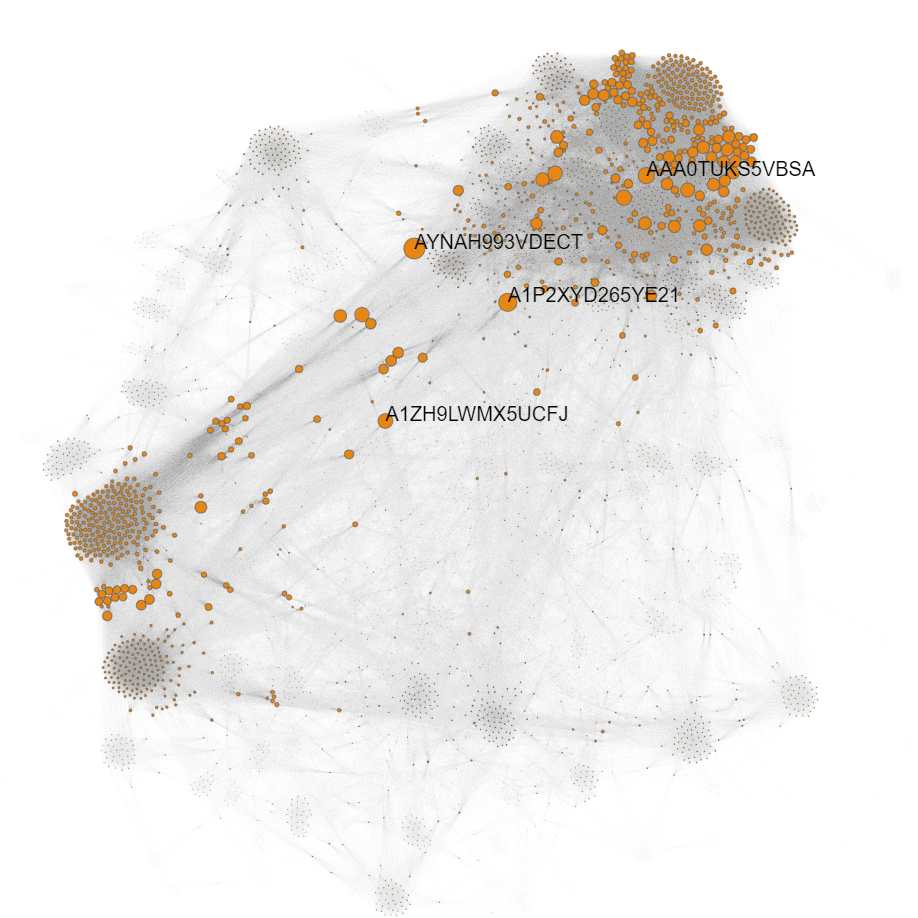

Culprits (with highest node degree):
- A1ZH9LWMX5UCFJ
- AYNAH993VDECT
- A1P2XYD265YE21
- AAA0TUKS5VBSA

## Product network

In order to tie our text and network analysis better together, we remove all products in the product dataframe that are not also in the review dataframe. 

In [31]:
asin_review_list = np.unique(list(review_df['asin']))

count = 0
related_products = []
rel = {}
idx = []
# loop over all products in product_df
for i in range(len(product_df)):
    asin = product_df.iloc[i]['asin']
    
    # if product is in the review df, find its related products.
    if asin in asin_review_list:
        related = product_df.iloc[i]['related']
        
        # check that the product has related items
        if str(related) != "nan":
            related_prod = []
            
            # loop over every key: also viewed, also bought, etc.
            for key in related.keys():
                # check that every related product is also in review_df
                for prod in related[key]:
                    if prod in asin_review_list:
                        related_prod.append(prod)
            rel[i] = related_prod
            related_products.append(related_prod)
        else:
            idx.append(i)
    
    else:
        idx.append(i)

In [32]:
# remove indices in original df
product_df2 = product_df.drop(idx)
product_df2.to_csv("data/product_df2.csv", index=False)
# make a new column 
product_df3 = product_df2.assign(related_products = related_products)
# explode column related_products
product_df3 = product_df3.explode('related_products')
product_df3.to_csv("data/product_df3.csv", index=False)

In [33]:
product_df3 = pd.read_csv("data/product_df3.csv")
product_df3

asin                                        description  \
0       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
1       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
2       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
3       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
4       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
...            ...                                                ...   
380298  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380299  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380300  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380301  B00KC0LGI8                                                NaN   
380302  B00KCJRVO2  Enjoy your gluten freedom. Chex Gluten Free Oa...   

                                                    title  \
0       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
1       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
2       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
3       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
4       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
...                                                   ...   
380298  Canadian Finest Maple Syrup - 100% Pure Certif...   
380299  Canadian Finest Maple Syrup - 100% Pure Certif...   
380300  Canadian Finest Maple Syrup - 100% Pure Certif...   
380301  Betty Crocker Dry Meals Suddenly Grain Salad, ...   
380302  General Mills Cereals Chex Gluten Free Oatmeal...   

                                                    imUrl  \
0       http://ecx.images-amazon.com/images/I/51LdEao6...   
1       http://ecx.images-amazon.com/images/I/51LdEao6...   
2       http://ecx.images-amazon.com/images/I/51LdEao6...   
3       http://ecx.images-amazon.com/images/I/51LdEao6...   
4       http://ecx.images-amazon.com/images/I/51LdEao6...   
...                                                   ...   
380298  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380299  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380300  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380301  http://ecx.images-amazon.com/images/I/61zqxqJi...   
380302  http://ecx.images-amazon.com/images/I/51r064m2...   

                                                  related  \
0       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
1       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
2       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
3       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
4       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
...                                                   ...   
380298  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380299  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380300  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380301  {'also_viewed': ['B00KSKIHVG', 'B00JWWM1T0', '...   
380302  {'also_viewed': ['B00LG89RX6', 'B00LG8GDQU', '...   

                                 salesRank                    categories  \
0        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
1        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
2        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
3        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
4        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
...                                    ...                           ...   
380298    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380299    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380300    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380301   {'Grocery & Gourmet Food': 97624}  [['Grocery & Gourmet Food']]   
380302  {'Grocery & Gourmet Food': 157656}  [['Grocery & Gourmet Food']]   

        price brand relat

We are only interested in products that have at least one subcategory other than "Grocery & Gourmet Food", since we want to look at how well these subcategories work as communities. Therefore we remove all products that do not have any subcategories

In [34]:
idx = []
categories = []
categories2 = {}
for i in range(len(product_df3)):
    if str(product_df3.iloc[i]['categories']) == str([['Grocery & Gourmet Food']]):
        idx.append(i)
    else:
        h = product_df3.iloc[i]['categories']
        h = h.replace("[","").replace("]","").replace(" '","").replace("'", "")
        h = h.split(",")
        
        categories2[product_df3['asin'].iloc[i]] = h[1]
        
        categories.append(h[1])
        

In [35]:
# remove indices in original df
product_df4 = product_df3.drop(idx)
# make a new column
product_df5 = product_df4.assign(category=categories)
# explode column related_products
product_df5
product_df5.to_csv("data/product_df5.csv", index=False)

In [36]:
product_df5 = pd.read_csv("data/product_df5.csv")
product_df5

asin                                        description  \
0      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
1      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
2      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
3      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
4      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
...           ...                                                ...   
13541  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13542  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13543  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13544  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13545  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   

                                                   title  \
0                      Ateco Food Coloring Kit, 6 colors   
1                      Ateco Food Coloring Kit, 6 colors   
2                      Ateco Food Coloring Kit, 6 colors   
3                      Ateco Food Coloring Kit, 6 colors   
4                      Ateco Food Coloring Kit, 6 colors   
...                                                  ...   
13541  Enfamil Reguline Milk-Based Powder with Iron I...   
13542  Enfamil Reguline Milk-Based Powder with Iron I...   
13543  Enfamil Reguline Milk-Based Powder with Iron I...   
13544  Enfamil Reguline Milk-Based Powder with Iron I...   
13545  Enfamil Reguline Milk-Based Powder with Iron I...   

                                                   imUrl  \
0      http://ecx.images-amazon.com/images/I/41F75K9F...   
1      http://ecx.images-amazon.com/images/I/41F75K9F...   
2      http://ecx.images-amazon.com/images/I/41F75K9F...   
3      http://ecx.images-amazon.com/images/I/41F75K9F...   
4      http://ecx.images-amazon.com/images/I/41F75K9F...   
...                                                  ...   
13541  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13542  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13543  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13544  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13545  http://ecx.images-amazon.com/images/I/510zYVQ8...   

                                                 related  \
0      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
1      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
2      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
3      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
4      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
...                                                  ...   
13541  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13542  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13543  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13544  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13545  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   

                               salesRank  \
0             {'Kitchen & Dining': 4494}   
1             {'Kitchen & Dining': 4494}   
2             {'Kitchen & Dining': 4494}   
3             {'Kitchen & Dining': 4494}   
4             {'Kitchen & Dining': 4494}   
...                                  ...   
13541  {'Health & Personal Care': 13464}   
13542  {'Health & Personal Care': 13464}   
13543  {'Health & Personal Care': 13464}   
13544  {'Health & Personal Care': 13464}   
13545  {'Health & Personal Care': 13464}   

                                              categories  price  \
0      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
1      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
2      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
3      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
4      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
...                                                  .

We prepare the edges for the product network, after which we can create the initial network: 

In [37]:
edge_dict = {}
nancount = 0
for i in range(len(product_df5)):
    if str(product_df5['related_products'].iloc[i]) != 'nan':
        key_ = tuple([product_df5.iloc[i]['asin'], product_df5.iloc[i]['related_products']])
        if key_ not in edge_dict.keys():
            edge_dict[key_] = 0
        edge_dict[key_] += 1
    else:
        nancount += 1
        
len(edge_dict)

10625

We create a networkx graph which has 358 nodes and 2814 edges. 

In [38]:
edges = edge_dict.keys()

G = nx.Graph()
G.add_nodes_from(product_df5['asin'])
print("Number of nodes in the product network:", len(G.nodes()))
G.add_edges_from(edges)
print("Number of edges in the product network:", len(G.nodes()))

Number of nodes in the product network: 358
Number of edges in the product network: 2814


Because adding the edges added some of the nodes with only the "Grocery & Gourmet food" category that we removed before, we remove them again. Furthermore, each node is given an attribute which corresponds to its category.

In [39]:
G3 = nx.Graph()

temp_df = product_df5.copy()

temp_df.set_index("asin", inplace = True)

G3.add_nodes_from(product_df5['asin'])

for edge in list(G.edges()):
#     print(edge)
    if edge[0] in list(G3.nodes()):
        if edge[1] in list(G3.nodes()):
            G3.add_edge(edge[0],edge[1])

# print(len(G3.nodes()))
cat2 = {}
for node in list(G3.nodes()):
    cat2[node] = np.unique(temp_df['category'].loc[node])[0]

nx.set_node_attributes(G3, cat2, name='category')

Some stats for the product network:

In [40]:
# number of nodes
n_nodes = G3.number_of_nodes()
print("number of nodes:", n_nodes)
# number of edges
n_edges = G3.number_of_edges()
print("number of edges:", n_edges)

# density
L_max = n_nodes * (n_nodes - 1)
density = n_edges / L_max
print("network density: {:2f}".format(density))

number of nodes: 358
number of edges: 1044
network density: 0.008169


In [41]:
# degree
print("mean degree", np.mean([i[1] for i in G3.degree()]))
print("median degree", np.median([i[1] for i in G3.degree()]))
print("mode of degree", stats.mode([i[1] for i in G3.degree()]).mode[0])
print("min degree", np.min([i[1] for i in G3.degree()]))
print("max degree", np.max([i[1] for i in G3.degree()]))

mean degree 5.832402234636872
median degree 5.0
mode of degree 0
min degree 0
max degree 38


We can now visualize the network

In [68]:
network = nw.get_filtered_network(G3, node_group_key="category")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

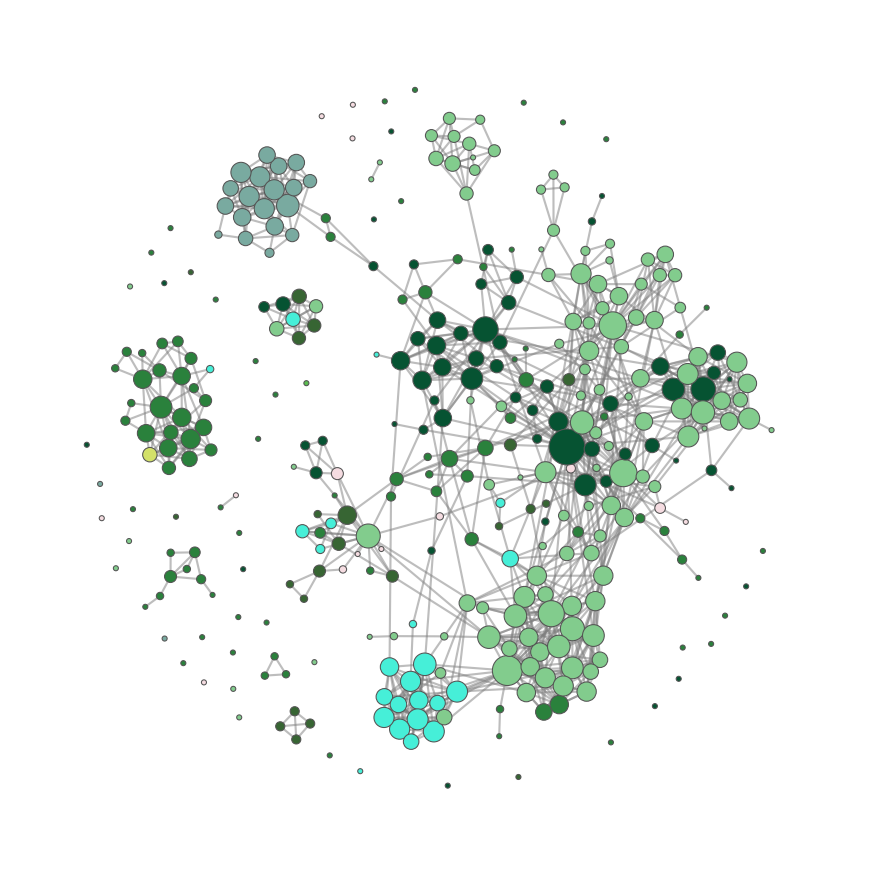

In [69]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

# 3. Tools, theory and analysis

## Review network

In [13]:
# this cell finds the IDs of the products that have been sampled
idxs = []
for i in range(len(products)):
    idx = np.where(review_df['asin'] == products[i])
    idxs.extend(idx[0])

In [14]:
culprits_df = review_df.iloc[idxs]
# find the review for all culprits
culprits = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA']
for culprit in culprits:
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    n = len(reviews)
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Number of reviews:", n)
    print("Sample review text:", reviews['reviewText'].iloc[np.random.randint(n)])
    print("Node degree in network:", G.degree[culprit])
    print("\n")


The reviewer name is: K. Stuckey "kateling"
Number of reviews: 82
Sample review text: I ordered this item based on the Jamba Juice name and was pretty disappointed. I like tart apples but this is not enjoyable at all. I didn't notice a significant increase in my energy either, I drank it during a break at work. Glad I got to try one for free, not worth the price.
Node degree in network: 3178


The reviewer name is: bsg2004
Number of reviews: 75
Sample review text: If you like to mix and match your coffee sources (all apologies to the coffee-purists out there), then this coffee's ideal use is to add flavor to your regular coffee. For example, if you are making unflavored coffee and want to give it some "flavor", adding a little bit (or more than a little bit depending on your preference) of this can add a different dimension to your otherwise regular coffee. With a smaller amount, this is more subtle, and not as over-powering for people who like some flavor, but not fully-flavored coffe

In [15]:
# let's look at the reviewers with the most reviews in our dataset. 
culprits_df.groupby(['reviewerID']).count().sort_values('asin', ascending=False).iloc[0:10]

asin  reviewerName  helpful  reviewText  overall  summary  \
reviewerID                                                                  
A3OXHLG6DIBRW8   204           203      204         204      204      204   
AY12DBB0U420B    180           180      180         180      180      180   
A2XKJ1KX6XUHYP   177           177      177         177      177      177   
A1UQBFCERIP7VJ   156           156      156         156      156      156   
AAA0TUKS5VBSA    149           148      149         149      149      149   
A2MNB77YGJ3CN0   145           145      145         145      145      145   
A25C2M3QF9G7OQ   141           140      141         141      141      141   
A1Z54EM24Y40LL   140           140      140         140      140      140   
A2YKWYC3WQJX5J   132           132      132         132      132      132   
AKMEY1BSHSDG7    127           126      127         127      127      127   

                unixReviewTime  reviewTime  
reviewerID                                  
A3OXHLG6DIBRW8             204         204  
AY12DBB0U420B              180         180  
A2XKJ1KX6XUHYP             177         177  
A1UQBFCERIP7VJ             156         156  
AAA0TUKS5VBSA              149         149  
A2MNB77YGJ3CN0             145         145  
A25C2M3QF9G7OQ             141         141  
A1Z54EM24Y40LL             140         140  
A2YKWYC3WQJX5J             132         132  
AKMEY1BSHSDG7              127         127

In some rows, the numbers do not match up. For example, in row 1 some values are 204, while it is 203 in another. Turns out, sometimes the reviewer name is recorded as 'nan' (not a number) 

In [16]:
np.unique(list(culprits_df[culprits_df['reviewerID'] == 'A3OXHLG6DIBRW8']['reviewerName']))

array(['C. Hill "CFH"', 'nan'], dtype='<U13')

In [17]:
# find reviewer names
reviewerIDs = culprits_df.groupby(['reviewerID']).count().sort_values('asin', ascending=False).iloc[0:10].index
for reviewerID in reviewerIDs:
    print(list(culprits_df[culprits_df['reviewerID'] == reviewerID]['reviewerName'])[0])

C. Hill "CFH"
Gary Peterson
NYFB
Margaret Picky
Nerd Alert
L. Mountford
Comdet
csm
Shannon Lastowski "Queen of Caffeine"
J. Arena


It is worth noting that among the identified users with the highest node degree, only one of them (Nerd Alert) is among the users with the top 10 most reviews. However, keep in mind that the network has an edge between two nodes if they have reviewed the same product. This means if a product has been reviewed by many people, then the users who have reviewed that product will have many edges. 

In [18]:
# add top 3 super users
culprits2 = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA'] + ['A3OXHLG6DIBRW8', 'AY12DBB0U420B', 'A2XKJ1KX6XUHYP']
most_reviewed_products_count = most_reviewed_products = culprits_df.groupby('asin').count().sort_values('reviewerID', ascending=False)

for culprit in culprits2:
    reviewed_products = list(culprits_df[culprits_df['reviewerID'] == culprit]['asin'])
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Reviewer:", culprit)
    print("Node degree in network:", G.degree[culprit])
    all_reviews = []
    for reviewed_product in reviewed_products:
        n = int(most_reviewed_products.loc[most_reviewed_products.index == reviewed_product]['reviewerID'])
#         print("The product {} has {} reviews".format(reviewed_product, n))
        all_reviews.append(n)
    print("Average number of reviews per reviewed product:", sum(all_reviews)/len(all_reviews)) # (average review score)
    print('\n')

The reviewer name is: K. Stuckey "kateling"
Reviewer: A1ZH9LWMX5UCFJ
Node degree in network: 3178
Average number of reviews per reviewed product: 74.3780487804878


The reviewer name is: bsg2004
Reviewer: AYNAH993VDECT
Node degree in network: 3701
Average number of reviews per reviewed product: 183.17333333333335


The reviewer name is: Andrea "Readaholic"
Reviewer: A1P2XYD265YE21
Node degree in network: 3629
Average number of reviews per reviewed product: 165.37313432835822


The reviewer name is: Nerd Alert
Reviewer: AAA0TUKS5VBSA
Node degree in network: 4012
Average number of reviews per reviewed product: 126.63087248322148


The reviewer name is: C. Hill "CFH"
Reviewer: A3OXHLG6DIBRW8
Node degree in network: 5155
Average number of reviews per reviewed product: 74.06862745098039


The reviewer name is: Gary Peterson
Reviewer: AY12DBB0U420B
Node degree in network: 2789
Average number of reviews per reviewed product: 20.13888888888889


The reviewer name is: NYFB
Reviewer: A2XKJ1KX6XU

The user with the highest number of reviews and node degree is C. Hill "CFH". However, writing many reviews does not equate to having a high node degree. For instance, the user "Gary Peterson" has written the second most reviews with 180, yet only have a node degree of 2,374. Comparatively, another user, "bsg2004" have only written 75 reviews, but have a much higher node degree of 3,701. Based on the average review score, we see that even though the users "Gary Peterson" and "NYFB" have written many reviews, the products that they review are not commonly reviewed by others. 

In conclusion, the reviewer network can be useful to identify some super users. However, the number of times a product has been reviewed needs to be accounted for, since it has a major impact on the node degree.

### Random network

The reviewer network is an example of a real-world network constructed using real data. We would like to construct a random network that have some of the same properties as the reviewer network, and then compare them. 

Using equation 3.2 from [1], we want to find the probability $p$ that a network with $N$ nodes has <$L$> expected edges:

$$
\begin{equation}
\text{<}L\text{>} = p \cdot \frac{N(N-1)}{2} 
\end{equation}
$$

Since there are $L=229767 = \text{<}L\text{>}$ edges in the network, the probability can be computed as:

$$
\begin{equation}
p = \frac{2\cdot L}{N(N-1)}
\end{equation}
$$

With the found value of $p$, the average degree of the network $\text{<}k\text{>}$ is computed using equation 3.3 in [1]:

$$
\begin{equation}
\text{<}k\text{>} = p(N-1)
\end{equation}
$$

In [19]:
#find p in equation 3.2: N is length of nodes, <L> is length of edges
N = len(G.nodes())
L = len(G.edges())
p = (2*L) / (N*(N-1))
print('p =', p)

# compute average degree using equation 3.3
k = p*(N-1)
print('k =',k)

p = 0.03923961850262633
k = 576.0375996185546


In [20]:
# we can also compute the average degree of G like this.
np.mean(list(dict(G.degree).values()))

576.0375996185546

Now, we build a random network with the same number of nodes as the reviewer network. With the probability $p = 0.039$, an edge is added between node $i$ and $j$.

In [21]:
#Code for generating random network
randomG = nx.Graph()
randomG.add_nodes_from([i for i in range(1,len(G.nodes))])
for i in range(1, len(G.nodes)+1):
    for j in range(i+1, len(G.nodes)+1):
        num = np.random.uniform()
        if num < p:
            randomG.add_edge(i,j)
    if i % 1000 == 0:
        print(f"{i}/{len(G.nodes)+1}")

1000/14682
2000/14682
3000/14682
4000/14682
5000/14682
6000/14682
7000/14682
8000/14682
9000/14682
10000/14682
11000/14682
12000/14682
13000/14682
14000/14682


In [22]:
print(f"The reviewer network contains {G.number_of_nodes()} nodes")
print(f"The reviewer network contains {G.number_of_edges()} edges")

print(f"The random network contains {randomG.number_of_nodes()} nodes")
print(f"The random network contains {randomG.number_of_edges()} edges")

The reviewer network contains 14681 nodes
The reviewer network contains 4228404 edges
The random network contains 14681 nodes
The random network contains 4230386 edges


### Degree distribution

In [23]:
import matplotlib.pyplot as plt
# define bin size using max and min
print(np.min([i[1] for i in G.degree]), np.max([i[1] for i in G.degree])) 

# define bin size using max and min
print(np.min([i[1] for i in randomG.degree]), np.max([i[1] for i in randomG.degree]))

8 5155
480 672


The degree distribution histograms are visualised with linear x-axis and y-axis. We tried with logarithmic axis on both plots, but it made the degree distribution for the reviewer network look Gaussian distributed which is misleading.

### Degree distribution for reviewer network

In [24]:
# bins = np.logspace(0, np.log10(5200), 50) # logarithmic binning
bins = np.linspace(0, 5200, 40) # linear binning
# make histogram
hist, edges = np.histogram([i[1] for i in G.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

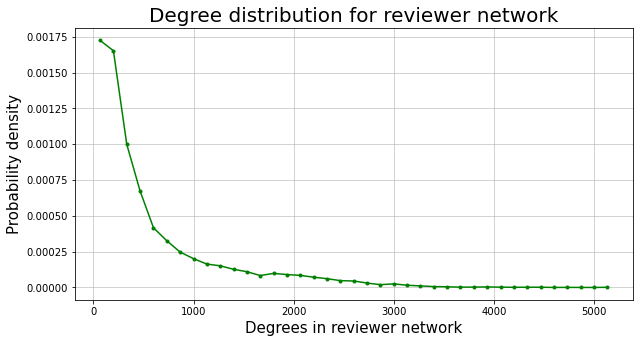

In [25]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(x, hist, marker=".", color='green')
ax.set_xlabel("Degrees in reviewer network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_title("Degree distribution for reviewer network", size=20)
ax.grid(alpha=0.7)

### Degree distribution for random network

In [26]:
# bins = np.logspace(np.log10(480), np.log10(680), 50) # logarithmic binning
bins = np.linspace(480, 680, 40) # linear binning
# make histogram
hist, edges = np.histogram([i[1] for i in randomG.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

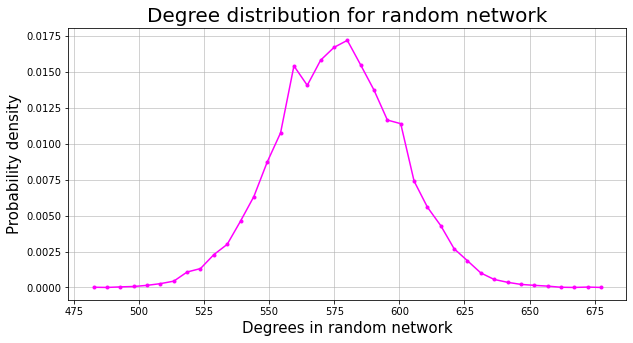

In [27]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(x, hist, marker=".", color='magenta')
ax.set_xlabel("Degrees in random network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_title("Degree distribution for random network", size=20)
ax.grid(alpha=0.7)

In [28]:
print("The average degree for the reviewer network is:", np.mean(list(dict(G.degree()).values())))
print("The average degree for the random network is:", np.mean(list(dict(randomG.degree()).values())))

print("The median degree for the reviewer network is:", np.median(list(dict(G.degree()).values())))
print("The median degree for the random network is:", np.median(list(dict(randomG.degree()).values())))

The average degree for the reviewer network is: 576.0375996185546
The average degree for the random network is: 576.3076084735372
The median degree for the reviewer network is: 312.0
The median degree for the random network is: 576.0


Both networks have around the same average degree, but their distributions vary. The degree distribution for the reviewer network is much more spread out, with degrees ranging from 8 to 5155, and skewed towards the left, indicating that smaller degrees are the most frequent. This is reflected in the median degree of the reviewer network, which is much lower than median degree of the random network.
On the other hand, the degree distribution for the random network has an almost identical mean and median, and it closely closely resembles a Gaussian distribution. According to [2], the degree distribution of a random network should follow a binomial distribution (which approximates a Gaussian distribution as the number of samples goes towards infinity).

For both networks we can compute the average clustering coefficient, which is a measure of the degree to which nodes tend to cluster together. Using equation 2.15 in [3], the local clustering coefficient for a node $i$ is computed as:
$$
\begin{equation}
C_i = \frac{2\cdot L_i}{k_i(k_i-1)}
\end{equation}
$$
where $L_i$ is the number of edges node $i$ has to its $k_i$ neighbours.

The average clustering coefficient is found by averaging the local clustering coefficient for all nodes. This is computed for both the reviewer network and the random network.

In [29]:
#Compute clustering coefficient using equation 2.15
CClist1 = []
for node in G.nodes():
    K = len(list(nx.neighbors(G,node)))
    L = nx.triangles(G,node)
    if K > 1:
        CClist1.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist1.append(0)
        
print("The average clustering coefficient for the reviewer network is:",np.mean(CClist1))

The average clustering coefficient for the reviewer network is: 0.40487891564180795


In [30]:
#Compute clustering coefficient using equation 2.15
CClist = []
for node in randomG.nodes():
    K = len(list(nx.neighbors(randomG,node)))
    L = nx.triangles(randomG,node)
    if K > 1:
        CClist.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist.append(0)
        
print("The average clustering coefficient for the random network is:",np.mean(CClist))

The average clustering coefficient for the random network is: 0.03925593444716841


We see that the average clustering coefficient is much larger for the reviewer network than the random network with a similar amount of nodes and edges. This is consistent with what is described in [4]: one would expect a real-life network with N nodes and L edges to have much higher clustering coefficients than a random network of similar size.

## Product Network

Here we take a closer look at a few select products, one of each category. Especially the products B009GCXEW4 and B0033HGLTG are interesting since B009GCXEW4 is a lone off-category node on an island mostly consisting of products with the "Beverages" category like B0033HGLTG.

In [42]:
asinlist = ["B000BIUH18","B0033HGLTG","B009GCXEW4","B0000DGF9V","B002R89LOE","B0088W8HKC","B000RL4UNA","B000EITYUU","B00016RH40"]


for asin in asinlist:
    print(asin)
    print(list(temp_df.loc[asin]['category'])[0])
    print('---------')

B000BIUH18
Baby Foods
---------
B0033HGLTG
Beverages
---------
B009GCXEW4
Gourmet Gifts
---------
B0000DGF9V
Fresh Flowers & Live Indoor Plants
---------
B002R89LOE
Breakfast Foods
---------
B0088W8HKC
Snack Foods
---------
B000RL4UNA
Candy & Chocolate
---------
B000EITYUU
Canned
---------
B00016RH40
Cooking & Baking
---------


We now want to look at communities. The communities made from the product categories are a focus of our analysis since we can get insight into how much Amazon tends to recommend products of the same category.

We want to calculate the modalities of the communities defined by the categories. The modality gives us a measure of how good the partition made from the category tags are, and allows us to compare it directly to other partitions, in particular a partition made with the Louvain algorithm. We define a function to calculate the modularity from the equation from the Network sience book: http://networksciencebook.com/chapter/9#modularity

"The modularity is a measure for the quality of the division of a network. A high modularity score means that the given division has divided the network into communities that are strongly interconnected and which does not have many connections outside of the community. The higher the modularity, the better the division is." [5]

In [71]:
def computeModularity(G, partition):

    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())


        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity

We make a louvain split, in order to compare how good the category split is to it. 

The louvain algorithm maximises modularity and agregates communities in a graph.[6]

Since it maximises modularity, we can directly compare its communities with those of the category partition. This will allow us to judge whether the related products are typically of the same category as the product they are related to, since if the modularity of the category partition is close to the louvain, it should be close to maximally interconnected


In [72]:
import community as community_louvain

#first compute the best partition
partition3 = community_louvain.best_partition(G3)

# number of communities in the partition
len(np.unique(list(partition3.values())))


69

In [73]:
print("modularity of category partition:", computeModularity(G3, 'category'))
H3 = G3.copy()
nx.set_node_attributes(H3, partition3, 'Louvain')

modularity = computeModularity(H3, 'Louvain')
print("The modularity of the louvain split network is:", modularity)

modularity of category partition: 0.46963262063093614
The modularity of the louvain split network is: 0.7587087682212532


We can also visualize the louvain split network:

In [74]:
network = nw.get_filtered_network(H3, node_group_key="Louvain")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

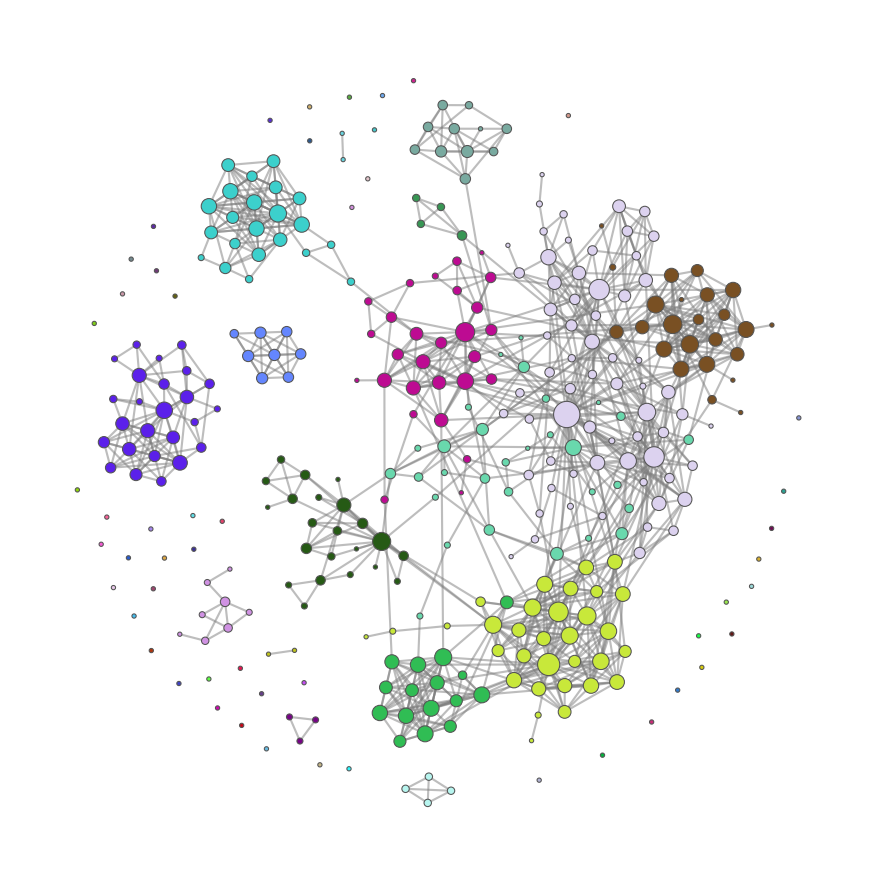

In [75]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [76]:
len(np.unique(list(nx.get_node_attributes(H3,'Louvain').values())))

69

To get insight into the overlap between the Louvain and the category partitioning we make a confusion matrix.

This confusion matrix shows what community the products belongs to in both the category and louvain partitions. This makes it easier to see if the louvain algorithm mimics certain categories, and which categories are the most interconnected. For example, if a category is contained almost entirely within a louvain community, it means that the category community was strongly interconnected. 

[Text(0, 0.5, 'Baby Foods'),
 Text(0, 1.5, 'Beverages'),
 Text(0, 2.5, 'Breakfast Foods'),
 Text(0, 3.5, 'Candy & Chocolate'),
 Text(0, 4.5, 'Canned'),
 Text(0, 5.5, 'Cooking & Baking'),
 Text(0, 6.5, 'Fresh Flowers & Live Indoor Plants'),
 Text(0, 7.5, 'Gourmet Gifts'),
 Text(0, 8.5, 'Snack Foods')]

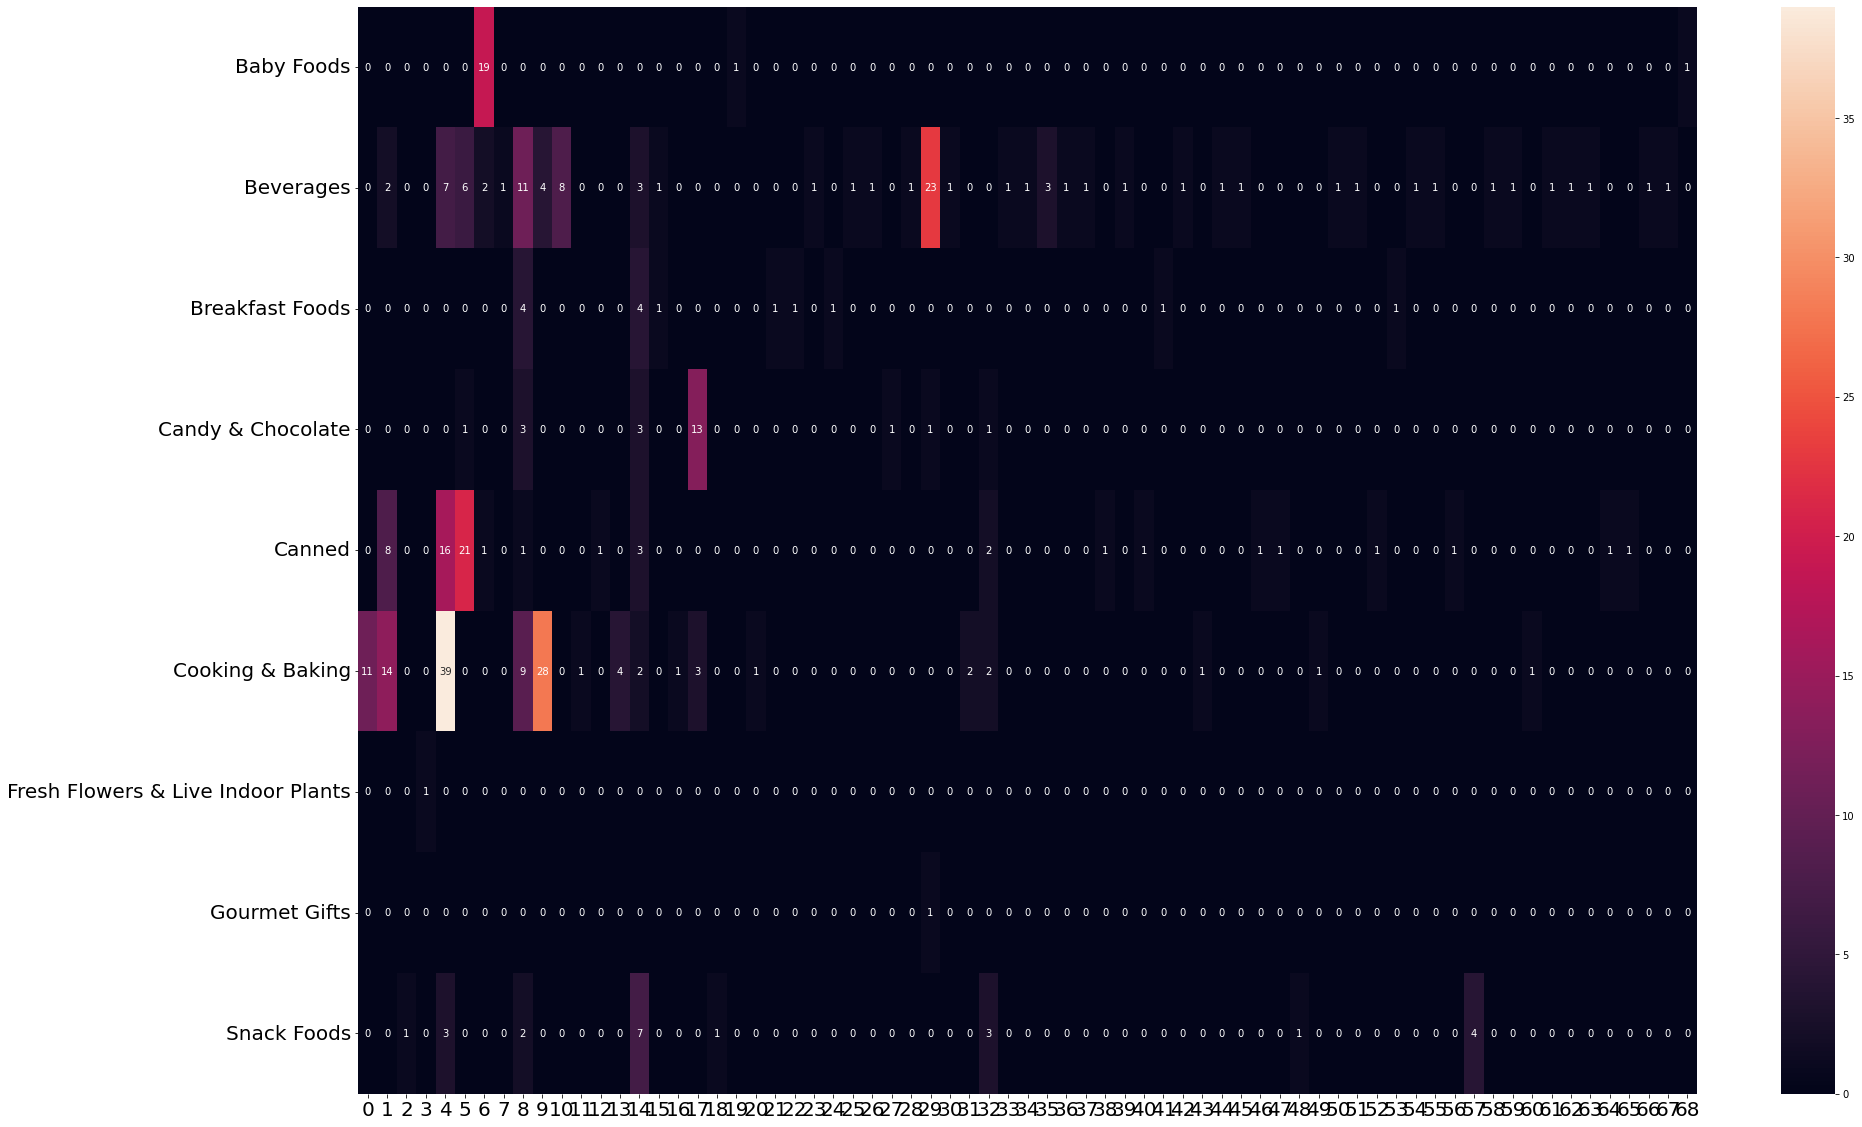

In [77]:
D = np.zeros([9,69])
cats = list(np.unique(list(nx.get_node_attributes(G3,'category').values())))
OG_dict = nx.get_node_attributes(G3, 'category')
for i in range(9):
    nodes = set([k for k in range(len(G3.nodes())) if nx.get_node_attributes(G3,'category')[list(G3.nodes())[k]] == cats[i]])
    for j in range(69):
        nodes2 = set([k for k in range(len(H3.nodes())) if nx.get_node_attributes(H3,'Louvain')[list(H3.nodes())[k]] == j])        
        D[i,j] = len(nodes2.intersection(nodes))
import seaborn as sns
plt.figure(figsize = (30,20))

ax = sns.heatmap(D, annot=True)
ax.set_xticklabels(range(69),size=20,rotation=0)
ax.set_yticklabels(np.unique(list(nx.get_node_attributes(G3,'category').values())),size=20,rotation=0)

It is hard to see what's going on in the confusion plot since there are so many bins in the Louvain split. Therefore we remove the singleton nodes and repeat the analysis to see if we find something new. Singleton nodes do not affect the modularity as they are not connected to any other notes. Therefore, we can safely remove without changing the measures.


In [78]:
G4 = G3.copy()
for node in list(G4.nodes()):
    if list(G4.edges(node)) == []:
        G4.remove_node(node)
print(len(G4.nodes()))

306


We then repeat the steps from before with the new singleton-free dataset.

In [79]:

#first compute the best partition
partition4 = community_louvain.best_partition(G4)

# number of communities in the partition
len(np.unique(list(partition4.values())))


17

In [80]:
print("modularity of category partition:", computeModularity(G4, 'category'))
H4 = G4.copy()
nx.set_node_attributes(H4, partition4, 'Louvain')

modularity = computeModularity(H4, 'Louvain')
print("The modularity of the louvain split network is:", modularity)

modularity of category partition: 0.46963262063093614
The modularity of the louvain split network is: 0.7603139083395721


In [81]:
network = nw.get_filtered_network(G4, node_group_key="category")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

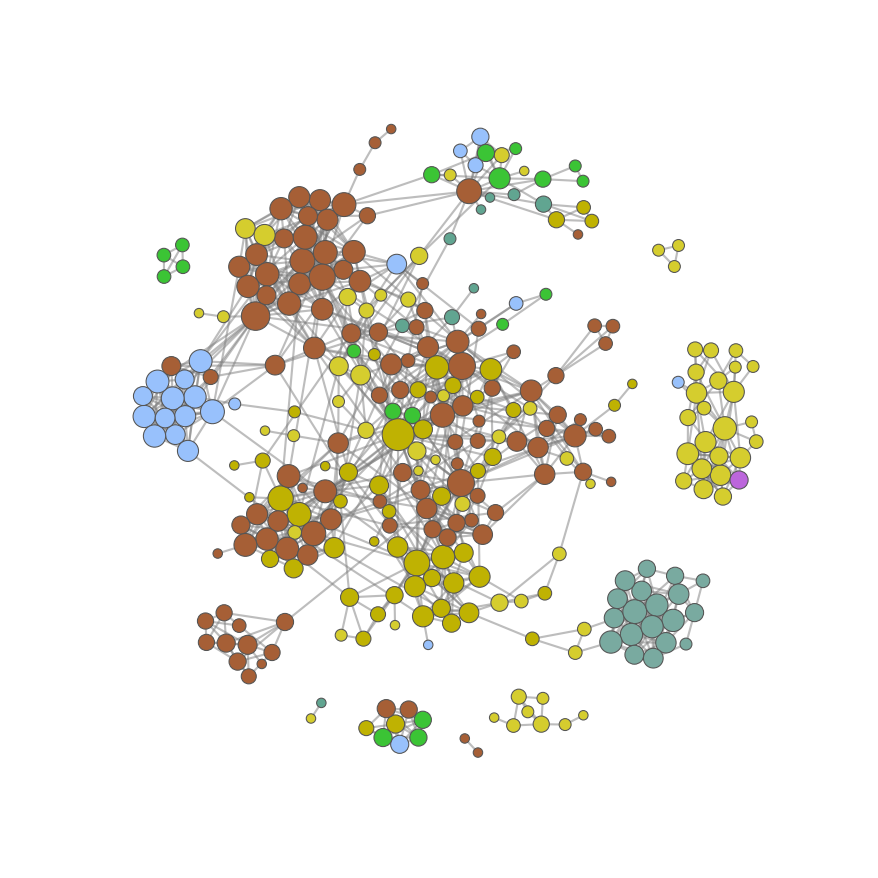

In [82]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [83]:
network = nw.get_filtered_network(H4, node_group_key="Louvain")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

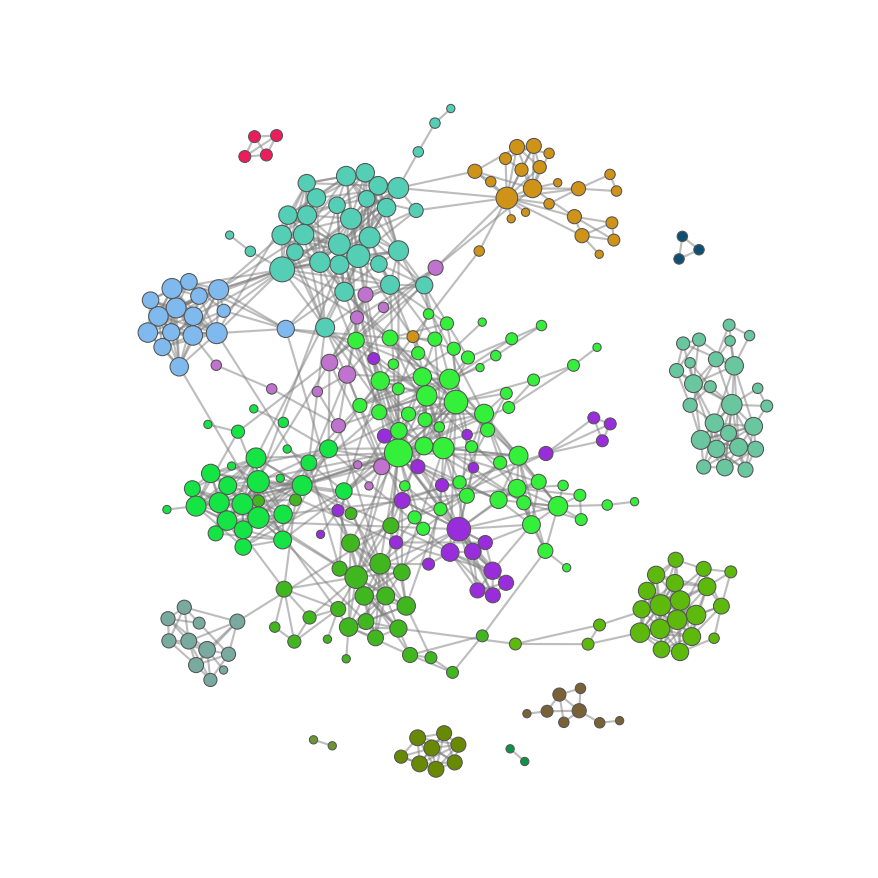

In [84]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

[Text(0, 0.5, 'Baby Foods'),
 Text(0, 1.5, 'Beverages'),
 Text(0, 2.5, 'Breakfast Foods'),
 Text(0, 3.5, 'Candy & Chocolate'),
 Text(0, 4.5, 'Canned'),
 Text(0, 5.5, 'Cooking & Baking'),
 Text(0, 6.5, 'Gourmet Gifts'),
 Text(0, 7.5, 'Snack Foods')]

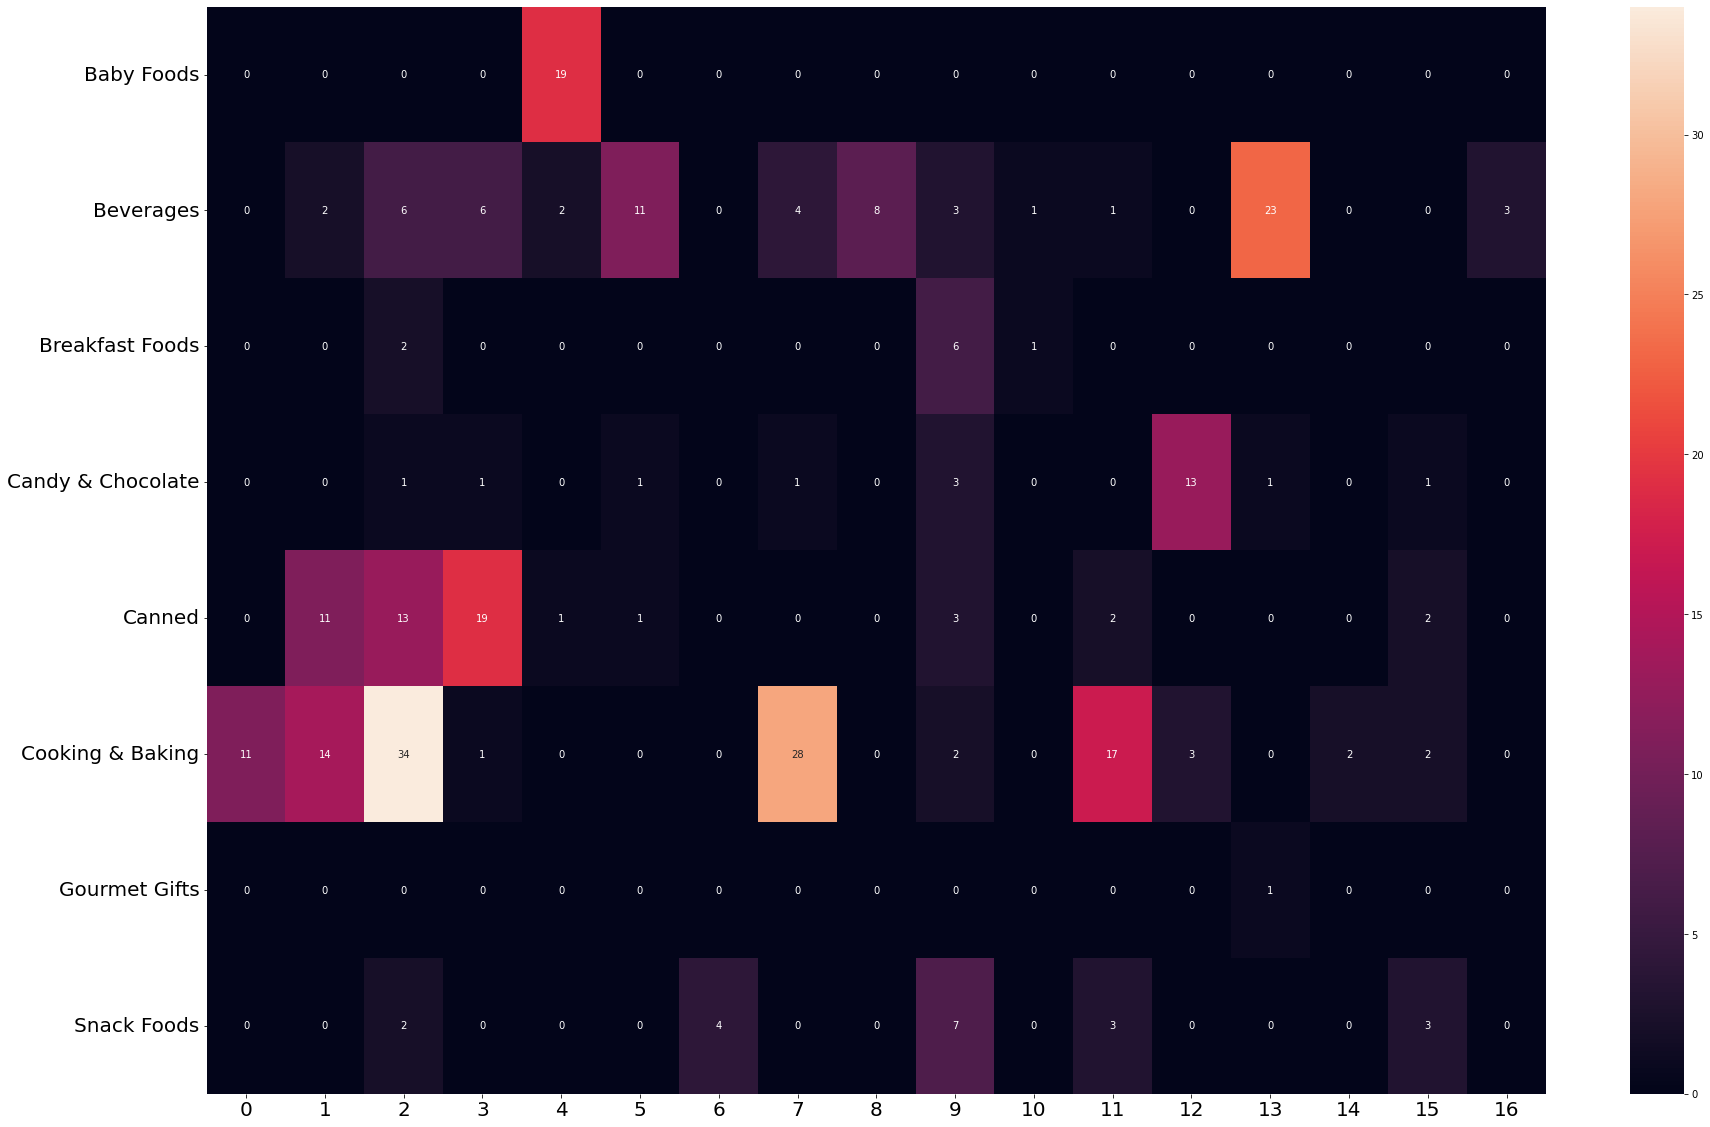

In [85]:
D = np.zeros([8,17])
cats = list(np.unique(list(nx.get_node_attributes(G4,'category').values())))
OG_dict = nx.get_node_attributes(G4, 'category')
for i in range(8):
    nodes = set([k for k in range(len(G4.nodes())) if nx.get_node_attributes(G4,'category')[list(G4.nodes())[k]] == cats[i]])
    for j in range(17):
        nodes2 = set([k for k in range(len(H4.nodes())) if nx.get_node_attributes(H4,'Louvain')[list(H4.nodes())[k]] == j])        
        D[i,j] = len(nodes2.intersection(nodes))

import seaborn as sns
plt.figure(figsize = (30,20))

ax = sns.heatmap(D, annot=True)
ax.set_xticklabels(range(17),size=20,rotation=0)
ax.set_yticklabels(np.unique(list(nx.get_node_attributes(G4,'category').values())),size=20,rotation=0)

The confusion matrix clearly shows that there are some communities in the category partition that are strongly interconnected. For example the "Baby Food" category is entirely contained within a Louvain community. Other larger categories like "Cooking & Baking" and "Beverages" are split up, which makes sense when you consider that they were bunched together in the plot.

## Text analysis

### TF-IDF

In [4]:
# Load the dataframe
product_df2 = pd.read_csv("data/product_df2.csv")

In [6]:
# remove indices with no subcategories
idx = []
# subcategories
categories = []
for i in range(len(product_df2)):
    if str(product_df2.iloc[i]['categories']) == str([['Grocery & Gourmet Food']]):
        idx.append(i)
    else:
        h = product_df2.iloc[i]['categories']
        h = h.replace("[","").replace("]","").replace(" '","").replace("'", "")
        h = h.split(",")
        
        categories.append(h[1])

# remove indices in original df
product_df6 = product_df2.drop(idx)
# make a new column
product_df7 = product_df6.assign(category=categories)

In [11]:
# Now we have categories for the products:
product_df7['category']

0                        Cooking & Baking
1                               Beverages
2                        Cooking & Baking
3                             Snack Foods
4      Fresh Flowers & Live Indoor Plants
                      ...                
353                            Baby Foods
354                            Baby Foods
355                                Canned
356                      Cooking & Baking
357                            Baby Foods
Name: category, Length: 358, dtype: object

In [12]:
# Seeing the amount of food categories:

print("Amount of products with subcategories: ", len(product_df7))

print('\nAmount of products of each category')
print('------------------------------------')
for i in range(len(np.unique(product_df7['category']))):
    cat = Counter(list(product_df7['category'])).most_common()[i]
    print(cat[0] + ": " + str(cat[1]))

Amount of products with subcategories:  358

Amount of products of each category
------------------------------------
Cooking & Baking: 120
Beverages: 95
Canned: 61
Candy & Chocolate: 23
Snack Foods: 22
Baby Foods: 21
Breakfast Foods: 14
Fresh Flowers & Live Indoor Plants: 1
Gourmet Gifts: 1


The code below tokenises the every review **text**, where **text** containts both the **review** and the **summary**.

In [ ]:
# # tokenise text
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

# stopwords = stopwords.words('english')
# alphabet = "abcdefghijklmnopqrstuvwxyz"
# char1 = "&#34" # quotation mark
# char2 = "/"


# all_reviews = []
# for text in review_df['text']:
#     tokens = word_tokenize(text)
#     review = []
#     for token in tokens:
#         token = token.lower()
#         # remove stopwords, punctuation and numbers
#         if token not in stopwords and token[0] in alphabet and token[-1] in alphabet:
#             # remove URLs
#             char_check = token in char1 or token in char2
#             if char_check:
#                 pass
#             else:
#                 review.append(token)
#     all_reviews.append(review)

# review_df['tokens'] = all_reviews
# review_df.to_csv("data/review_df.csv", index=False)

To save time, this review_df is saved, and then loaded in the code snippet below:

In [14]:
review_df = pd.read_csv("data/review_df.csv")

# read_csv is a string, so we have to convert the string to a list again
token_reviews = []
for i in range(len(review_df['tokens'])):
    token_reviews.append(review_df.iloc[i]['tokens'][2:-2].replace(" ","").replace("'","").split(","))
    
review_df['tokens'] = token_reviews

In [20]:
# Examples:
review_df['tokens']

0         [another, flavor, kit, kat, taste, unique, bit...
1         [bought, impulse, comes, japan, amused, family...
2         [really, good, great, gift, fan, green, tea, e...
3         [never, curious, see, like, smooth, great, sub...
4         [looking, forward, trying, hearing, popular, j...
                                ...                        
151249    [delicious, gluten-free, oatmeal, tried, regul...
151250    [many, selections, instant, oatmeal, cereals, ...
151251    [usually, review, cds, dvds, well, entertainme...
151252    [son, enjoyed, oatmeal, packets, fond, maple, ...
151253    [like, eat, oatmeal, mornings, usually, buy, q...
Name: tokens, Length: 151254, dtype: object

A dictionary for each of the 358 products is created, containing all its tokens:

In [21]:
prod_dict = {}
for product in product_df7['asin']:
    prod_dict[product] = []
    
for i in range(len(review_df)):
    prod = review_df.iloc[i]['asin']
    if prod in prod_dict:
        review = review_df.iloc[i]['tokens']
        prod_dict[prod].extend(review)

In [37]:
#Example:
prod_dict[list(prod_dict.keys())[8]][:10]

['used',
 'children',
 'went',
 'back',
 'work',
 'needed',
 'pump',
 'enough',
 'milk',
 'could']

Now we want a dictionary containing the tokens for each subcategory:

In [32]:
cat_dict = {}
for cat in np.unique(categories):
    cat_dict[cat] = []

for prod in prod_dict.keys():
    cat = product_df7.iloc[np.where(product_df7['asin']==prod)]['category'].iloc[0]
    cat_dict[cat].extend(prod_dict[prod])

In [36]:
# Example
cat_dict['Baby Foods'][:10]

['formula',
 'works',
 'great',
 'bit',
 'cheaper',
 'amazon',
 'local',
 'wal-mart',
 'reduced',
 'daughters']

In [38]:
# Amount of tokens in each subcategory:
for key in cat_dict.keys():
    print('N tokens, {0}: {1}'.format(key, len(cat_dict[key])))

N tokens, Baby Foods: 37730
N tokens, Beverages: 72767
N tokens, Breakfast Foods: 7766
N tokens, Candy & Chocolate: 8798
N tokens, Canned: 45528
N tokens, Cooking & Baking: 85303
N tokens, Fresh Flowers & Live Indoor Plants: 257
N tokens, Gourmet Gifts: 246
N tokens, Snack Foods: 12227


We see that the categories containing only a single product each (Flowers & Plants and Gourmet Gifts) have a very small amount of tokens.


Now, we make the dictionaries for the dictionaries:

In [ ]:
# # Make IDF dict
# document_freq_dic = {}
# IDF = {}
# N = len(cat_dict)
# for key in cat_dict.keys():
#     print("Category:",key)
#     unique_term = np.unique(cat_dict[key])
#     for t in unique_term:
#         if t not in document_freq_dic.keys():
#             document_freq_dic[t] = 0
#         document_freq_dic[t] += 1
#         IDF[t] = np.log(N/document_freq_dic[t])
        
        
# df_document_freq = pd.DataFrame.from_dict(document_freq_dic, orient='index', columns=['doc_freq'])
# df_document_freq.to_csv("document_freq.csv")

# df_idf = pd.DataFrame.from_dict(IDF, orient='index', columns=['IDF'])
# df_idf.to_csv("IDF.csv")

In [47]:
# Loading the IDF dictionary to save time:
IDF_df = pd.read_csv("IDF.csv", index_col=0)

# We see there's one IDF score for each case: 9/9, 8/9, 7/9, ..., 1/9:
np.unique(IDF_df['IDF'])

array([0.        , 0.11778304, 0.25131443, 0.40546511, 0.58778666,
       0.81093022, 1.09861229, 1.5040774 , 2.19722458])

Below the TF scores alongside TF-IDF scores are shown:

In [48]:
for key in cat_dict.keys():
    unique_terms = np.unique(cat_dict[key])
    TF_IDF = {}
    # top 10 TF for each stock
    print("Category:", key)
    print("Top 10 TF words")
    a = dict(Counter(cat_dict[key],sorted=True))
    print(sorted(a, key=a.get, reverse=True)[:10])
    counts = sorted(a.values(), reverse=True)[:10]
    tf = [count/len(cat_dict[key]) for count in counts]
    print(np.round(tf,3))


    # top 10 TF-IDF for each stock
    for t in unique_terms:
        if t in IDF_df.index:
            tf = a[t]/len(cat_dict[key])
            TF_IDF[t] = IDF_df['IDF'][t] * tf
    print("Top 10 TF-IDF words")
    print(sorted(TF_IDF, key=TF_IDF.get, reverse=True)[:10])
    b = sorted(TF_IDF.values(), reverse=True)[:10]
    print(np.round(b,3))
    print("\n")

Category: Baby Foods
Top 10 TF words
['formula', 'milk', '"nt"', 'baby', 'like', 'enfamil', 'corn', 'good', 'syrup', 'one']
[0.029 0.014 0.013 0.013 0.009 0.009 0.008 0.008 0.008 0.008]
Top 10 TF-IDF words
['formula', 'enfamil', 'baby', 'infant', 'enfagrow', 'milk', 'formulas', 'transitions', 'toddler', 'solids']
[0.023 0.014 0.008 0.007 0.006 0.006 0.006 0.004 0.004 0.004]


Category: Beverages
Top 10 TF words
['tea', '"nt"', 'like', 'good', 'coffee', 'taste', 'one', 'flavor', 'green', 'great']
[0.026 0.013 0.012 0.011 0.01  0.009 0.008 0.008 0.008 0.008]
Top 10 TF-IDF words
['tea', 'pads', 'pad', 'keurig', 'teas', 'cooktop', 'scotch-brite', 'taste', 'drink', 'tazo']
[0.015 0.006 0.003 0.003 0.003 0.003 0.002 0.002 0.002 0.002]


Category: Breakfast Foods
Top 10 TF words
['bars', 'bar', 'like', 'good', '"nt"', 'taste', 'great', 'chocolate', 'snack', 'one']
[0.025 0.02  0.019 0.015 0.014 0.014 0.011 0.011 0.01  0.009]
Top 10 TF-IDF words
['bars', 'bar', 'taste', 'larabar', 'larabars', 

We get rid of many of the "boring" words, such as "not", "like", "good", when using TF-IDF scores insteaf of purely TF. 

---

Testing some TF-IDF scores for baby foods: 

In [105]:
# testing tokens from TF-IDF for baby foods:
baby_tokens = ['formula', 'enfamil', 'baby', 'infant', 'enfagrow', 'milk', 'formulas', 'transitions', 'toddler', 'solids']
for token in baby_tokens:
    print(token,":", round(text2happiness(token),3))

formula : 5.069
enfamil : 5.097
baby : 4.85
infant : 5.047
enfagrow : 4.87
milk : 5.315
formulas : 5.065
transitions : 5.111
toddler : 4.86
solids : 5.16


### Wordclouds

The TF-IDF scores from before are now used to visualise wordclouds for the 6 biggest food categories.

First we create a mask_dictionary containing the 6 masks for the wordclouds:

In [49]:
mask_dir = r'C:\Users\Andreas\Documents\DTU filer\02467 - Social science\Øvelser\Project\data\masks'
mask_imgs = os.listdir(mask_dir)
print(mask_imgs)
mask_cats = cat_dict.keys()

six_masks = ['Baby Foods', 'Beverages', 'Candy & Chocolate', 'Canned', 'Cooking & Baking', 'Snack Foods']
mask_idx = [3,6,1,5,4,0]
mask_dict = {}
for i in range(6):
    mask_dict[six_masks[i]] = mask_imgs[mask_idx[i]] 
    
mask_dict

['burger_bin.png', 'candy_bin.png', 'muffin_bin.png', 'pacifier_bin.png', 'pan_bin.png', 'tin_bin.png', 'wine_bin.png']


{'Baby Foods': 'pacifier_bin.png',
 'Beverages': 'wine_bin.png',
 'Candy & Chocolate': 'candy_bin.png',
 'Canned': 'tin_bin.png',
 'Cooking & Baking': 'pan_bin.png',
 'Snack Foods': 'burger_bin.png'}

#### Clipart images from:
https://icon-library.com/icon/at-icon-png-28.html burger <br>
https://svgsilh.com/image/146690.html candy <br>
https://www.istockphoto.com/search/2/image?mediatype=illustration&phrase=pacifier pacifier <br>
https://cdn.create.vista.com/api/media/small/193917378/stock-vector-frying-pan-icon-in-flat pan <br>
https://t4.ftcdn.net/jpg/02/74/47/29/240_F_274472965_p7RnT0D13PXObI2x033DwTL0l19FJv9y.jpg can <br>
https://prosteps.cloudimg.io/v7m/resizeinbox/1000x1000/fsharp0/https://tilroy.s3.eu-west-1.amazonaws.com/472/product/14873454940331341306439275.png wine

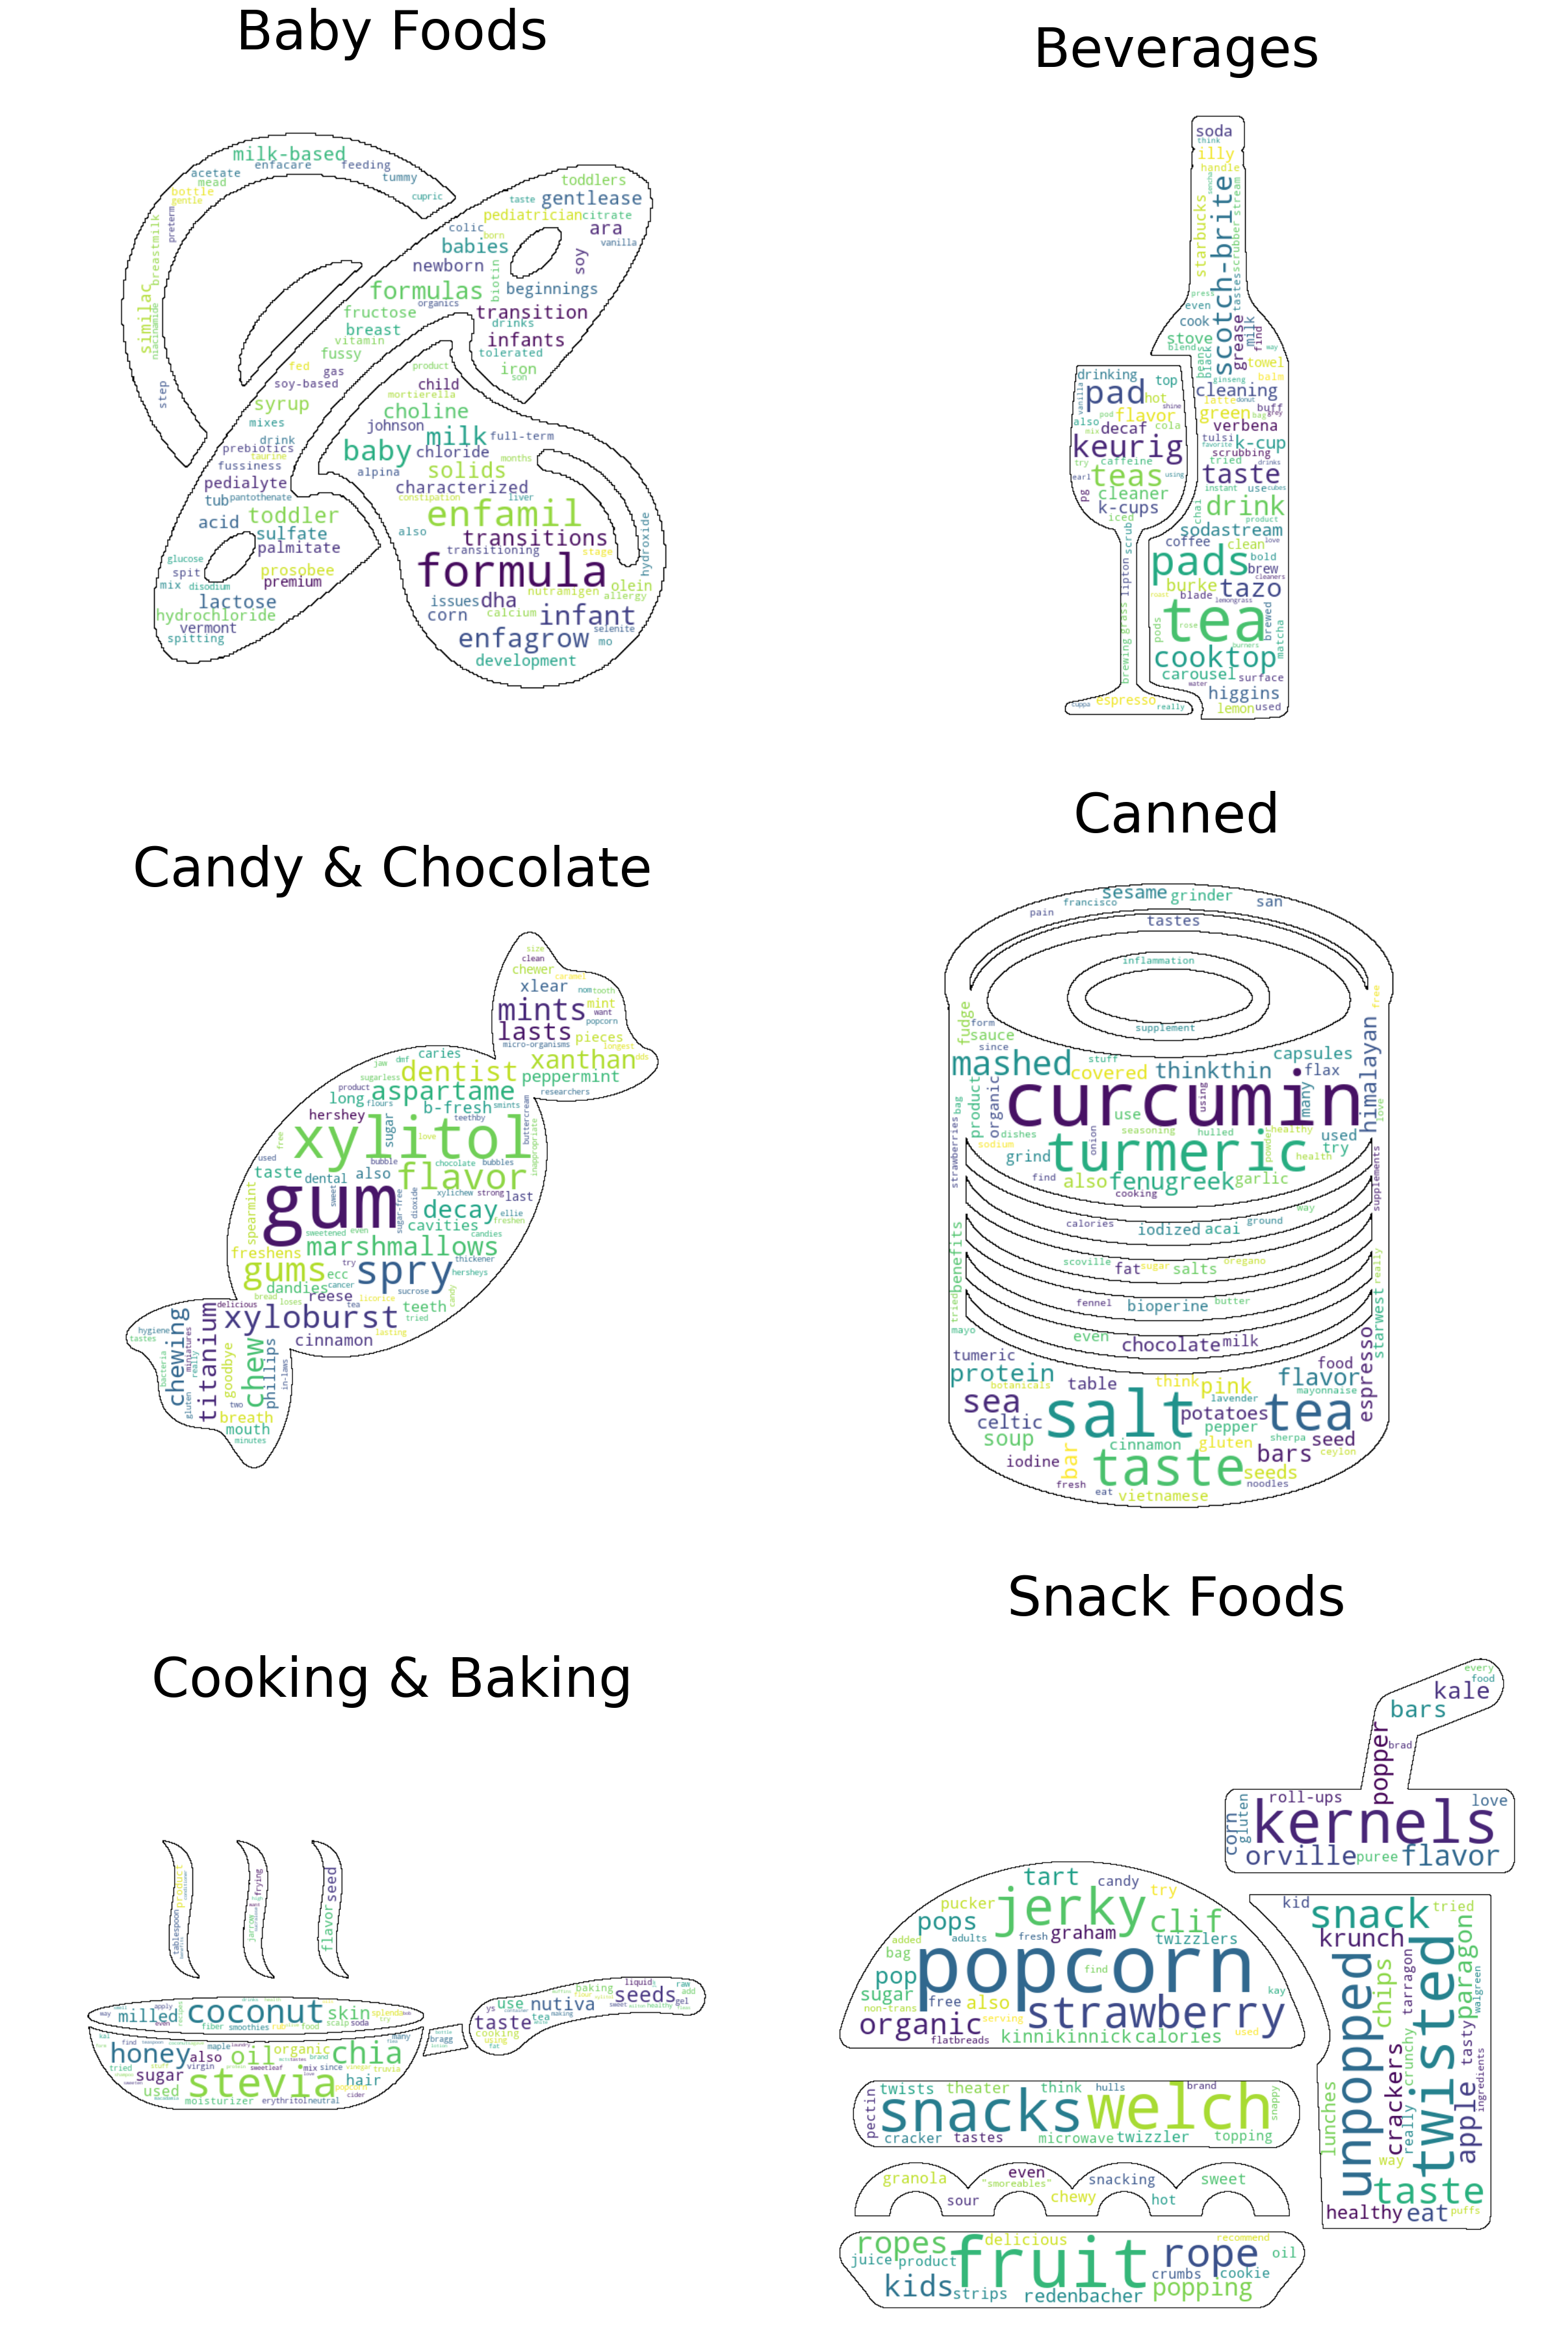

In [50]:
## wordcloud code inspired from: https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py 
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

fig = plt.figure(figsize=(20,30),dpi=120,constrained_layout=True)
i=1
for cat in six_masks:
    unique_terms = np.unique(cat_dict[cat])
    TF_IDF = {}
    a = dict(Counter(cat_dict[cat],sorted=True))

    for t in unique_terms:
        if t in IDF_df.index:
            tf = a[t]/len(cat_dict[cat])
            TF_IDF[t] = IDF_df['IDF'][t] * tf
    
    # make wordcloud from TF-IDF
    # read the mask image
    mask = np.array(Image.open(path.join(d, "data","masks",mask_dict[cat])))
    # plate_mask = 255 - plate_mask
    mask = 255 * mask
    wc = WordCloud(background_color="white", mask=mask, contour_width=1, contour_color='black', max_words=100)
    
    wordcloud = wc.generate_from_frequencies(TF_IDF)

    ax = fig.add_subplot(3,2,i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(cat, size=50)
    ax.axis("off")
    i+=1

plt.show()

Below we check how many times the following words **"stevia", "xylitol", "keurig"** are present in each food category:

In [51]:
print("Amount of STEVIA:\n________________")
for cat in cat_dict.keys():
    if 'stevia' in Counter(cat_dict[cat]).keys():
        print(cat, Counter(cat_dict[cat])['stevia'])
    else:
        print(cat, 0)

print("\nAmount of XYLITOL:\n________________")
for cat in cat_dict.keys():
    if 'xylitol' in Counter(cat_dict[cat]).keys():
        print(cat, Counter(cat_dict[cat])['xylitol'])
    else:
        print(cat, 0)
        
print("\nAmount of KEURIG:\n________________")
for cat in cat_dict.keys():
    if 'keurig' in Counter(cat_dict[cat]).keys():
        print(cat, Counter(cat_dict[cat])['keurig'])
    else:
        print(cat, 0)

Amount of STEVIA:
________________
Baby Foods 0
Beverages 30
Breakfast Foods 0
Candy & Chocolate 0
Canned 4
Cooking & Baking 448
Fresh Flowers & Live Indoor Plants 0
Gourmet Gifts 0
Snack Foods 0

Amount of XYLITOL:
________________
Baby Foods 0
Beverages 0
Breakfast Foods 0
Candy & Chocolate 118
Canned 0
Cooking & Baking 42
Fresh Flowers & Live Indoor Plants 0
Gourmet Gifts 0
Snack Foods 1

Amount of KEURIG:
________________
Baby Foods 0
Beverages 96
Breakfast Foods 0
Candy & Chocolate 0
Canned 0
Cooking & Baking 0
Fresh Flowers & Live Indoor Plants 0
Gourmet Gifts 0
Snack Foods 0


### Sentiment analysis

Now for the sentiment analysis. We start by loading the labTM dataframe, and then create a dictionary for ourselves of happiness scores:

In [52]:
# compute happiness
# load labMT dataframe 
labMT = pd.read_csv('data\Hedonometer.csv')
# make as dic
df_happy = labMT.set_index("Word")
df_happy

Rank  Word in English  Happiness Score  \
Word                                                       
laughter             0         laughter             8.50   
happiness            1        happiness             8.44   
love                 2             love             8.42   
happy                3            happy             8.30   
laughed              4          laughed             8.26   
...                ...              ...              ...   
quarantined      10182      quarantined             2.14   
sanitizer        10183        sanitizer             5.14   
self-quarantine  10184  self-quarantine             3.14   
ventilator       10185       ventilator             2.98   
ventilators      10186      ventilators             3.26   

                 Standard Deviation of Ratings  
Word                                            
laughter                                  0.93  
happiness                                 0.97  
love                                      1.11  
happy                                     0.99  
laughed                                   1.16  
...                                        ...  
quarantined                               1.01  
sanitizer                                 1.55  
self-quarantine                           1.80  
ventilator                                1.70  
ventilators                               1.97  

[10187 rows x 4 columns]

We use the function for giving a happiness score given a list of tokens (from week 7)

In [53]:
# text to happiness (from week 7)
def text2happiness(token_list):
    dic = {}
    scores_dic = {}
    for token in token_list:
        if token in list(df_happy['Word in English']):
            score = float(df_happy.loc[df_happy['Word in English'] == token]['Happiness Score'])
            scores_dic[token] = score
            dic[token] = dic.get(token, 0) + 1

    happiness_score = 0
    for key in dic.keys():
        p = dic[key] / sum(dic.values())
        h_avg = scores_dic[key]
        happiness_score += p*h_avg

    return happiness_score

We create a review_df2, which is indexed by product name ("asin"):

In [54]:
# set index = asin (product name) so we can easily make tokens for the product_df
review_df2 = review_df.copy()

review_df2.set_index("asin", inplace = True)

Creating a tokens column for each product:

In [56]:
all_prod_tokens = []
for prod in product_df7['asin']:
    prod_tokens = []
    for review in review_df2.loc[prod]['tokens']:
        prod_tokens.extend(review)
    
    all_prod_tokens.append(prod_tokens)
    
product_df7['tokens'] = all_prod_tokens

We calculate happiness scores for the first 5000 reviews:

In [74]:
# haps = []
# i = 0
# for i in range(0,5000):
#     hap = text2happiness(review_df2['tokens'].iloc[i])
#     haps.append(hap)
#     if (i+1)%1000 == 0:
#         print(i+1)

# with open("haps5000", "w") as fp:
#     json.dump(haps, fp)

1000
2000
3000
4000
5000


In [83]:
with open("haps5000", "r") as fp:
    haps = json.load(fp)

#### Some examples of reviews with low/high happiness scores:

In [84]:
# Minimum / maximum happiness in the 5000 reviews: 
print(np.min(haps), np.max(haps))

4.476666666666666 7.306666666666667


#### Showing the 5 most negative reviews:

In [76]:
k = 5
idx = np.argsort(haps)

print("NEGATIVE REVIEWS:\n__________________")
for i in range(k):
    # low
    print("Product:")
    print(product_df2.iloc[product_df2.loc[product_df2['asin'] == review_df.iloc[idx[i]]['asin']].index[0]]['title'])
    print("Asin:",review_df.iloc[idx[i]]['asin'])
    print("\nReview:")
    print(review_df2.iloc[idx[i]]['text'])
    print("\nRating:",review_df2.iloc[idx[i]]['overall'])
    print("\nHappiness:",round(haps[idx[i]],2))
    print('\nTokens:\n---------')
    for token in review_df2.iloc[idx[i]]['tokens']:
        if token in list(df_happy['Word in English']):
            score = float(df_happy.loc[df_happy['Word in English'] == token]['Happiness Score'])
            print(token, score)
    print('\n')

NEGATIVE REVIEWS:
__________________
Product:
Dave's Original Insanity Hot Sauce - 5oz
Asin: B0000DID5R

Review:
but also very temporaryMega heat, without the lasting burn of other sauces, which means I can consume more in less time. Is very insanity

Rating: 5.0

Happiness: 4.48

Tokens:
---------
also 5.42
heat 4.16
without 3.54
burn 2.92
means 5.64
consume 5.31
less 4.1
time 5.74
insanity 3.46


Product:
Orbit Cinnamint Sugarfree Gum, 14-Piece Packs (Pack of 12)
Asin: B0000DGDMO

Review:
After the dentyne fire variety this was dull n doesn't last as long. Not bad if u can't stand the stuff that burns Not that hot or long lasting

Rating: 4.0

Happiness: 4.58

Tokens:
---------
fire 3.8
variety 6.78
dull 3.24
n 4.82
last 3.74
long 4.74
bad 2.64
u 5.52
ca 5.1
stand 5.6
stuff 5.58
burns 2.78
hot 5.02
long 4.74


Product:
General Mills Cheerios, Honey Nut 2 Bags, 55 Ounce
Asin: B000329OOI

Review:
This product contains GMO's Known to cause Cancer and Organ Failure, Im sorry but I will n

#### ... and the 5 most positive review:

In [77]:
k=5

print("POSITIVE REVIEWS:\n__________________")
for i in range(k):
    # low
    print("Product:")
    print(product_df2.iloc[product_df2.loc[product_df2['asin'] == review_df.iloc[idx[-i-1]]['asin']].index[0]]['title'])
    print("Asin:",review_df.iloc[idx[-i-1]]['asin'])
    print("\nReview:")
    print(review_df2.iloc[idx[-i-1]]['text'])
    print("\nRating:",review_df2.iloc[idx[-i-1]]['overall'])
    print("\nHappiness:",round(haps[idx[-i-1]],2))
    print('\nTokens:\n---------')
    for token in review_df2.iloc[idx[-i-1]]['tokens']:
        if token in list(df_happy['Word in English']):
            score = float(df_happy.loc[df_happy['Word in English'] == token]['Happiness Score'])
            print(token, score)
    print('\n')

POSITIVE REVIEWS:
__________________
Product:
Kashi GOLEAN Bar Crisp Chocolate Caramel, 12 - 1.59-Ounce Bars
Asin: B0007LXU8Q

Review:
Pros:ProteinFiberFillingTastyEasy for travelCons:Very crunchyOverall:Delicious and a great fast breakfast Great for on-the-go breakfast

Rating: 4.0

Happiness: 7.31

Tokens:
---------
delicious 7.92
great 7.88
fast 6.44
breakfast 6.86
great 7.88
breakfast 6.86


Product:
Candy Crate 1960's Retro Candy Gift Box
Asin: B0001R04LM

Review:
Fun candy that made a fun gift for my Dad. It was well put together with novelty candies and he enjoyed the gift. fun candy

Rating: 5.0

Happiness: 7.22

Tokens:
---------
fun 7.96
candy 7.52
made 5.96
fun 7.96
gift 7.72
dad 7.02
well 6.68
put 5.04
together 6.8
enjoyed 8.02
gift 7.72
fun 7.96
candy 7.52


Product:
Chex Snack Mix Bold Party Blend, 8.75-Ounce Bags (Pack of 12)
Asin: B00099XNG0

Review:
These are yummy!! A+++

Rating: 5.0

Happiness: 7.22

Tokens:
---------
yummy 7.22


Product:
Kashi TLC Chewy Granola Bar

Now we create a happiness score for each of the 358 products:

In [86]:
# # happiness scores for each product (subcategory DF)
# haps = []
# i = 0
# for prod in product_df7['tokens']:
#     hap = text2happiness(prod)
#     haps.append(hap)
#     i+=1
#     if i%100==0:
#         print(i)
    
# product_df7['happiness score'] = haps
# product_df7.to_csv("data/product_df_haps.csv", index=False)

In [96]:
# loading the csv with happiness scores:
product_df7 = pd.read_csv("data/product_df_haps.csv")

product_df7['happiness score']

0      5.996557
1      5.860385
2      5.958070
3      5.757689
4      5.972682
         ...   
353    5.833470
354    5.887169
355    5.554788
356    5.686401
357    5.843450
Name: happiness score, Length: 358, dtype: float64

We create a mean rating for each product and add it as a column in the dataframe:

In [97]:
all_ratings = []
for prod in product_df7['asin']:
    ratings = []
    for rating in review_df2.loc[prod]['overall']:
        ratings += [rating]
    
    all_ratings.append(np.mean(ratings))
    
product_df7['mean rating'] = all_ratings

**Plotting the figure of sentiment vs. mean rating:**

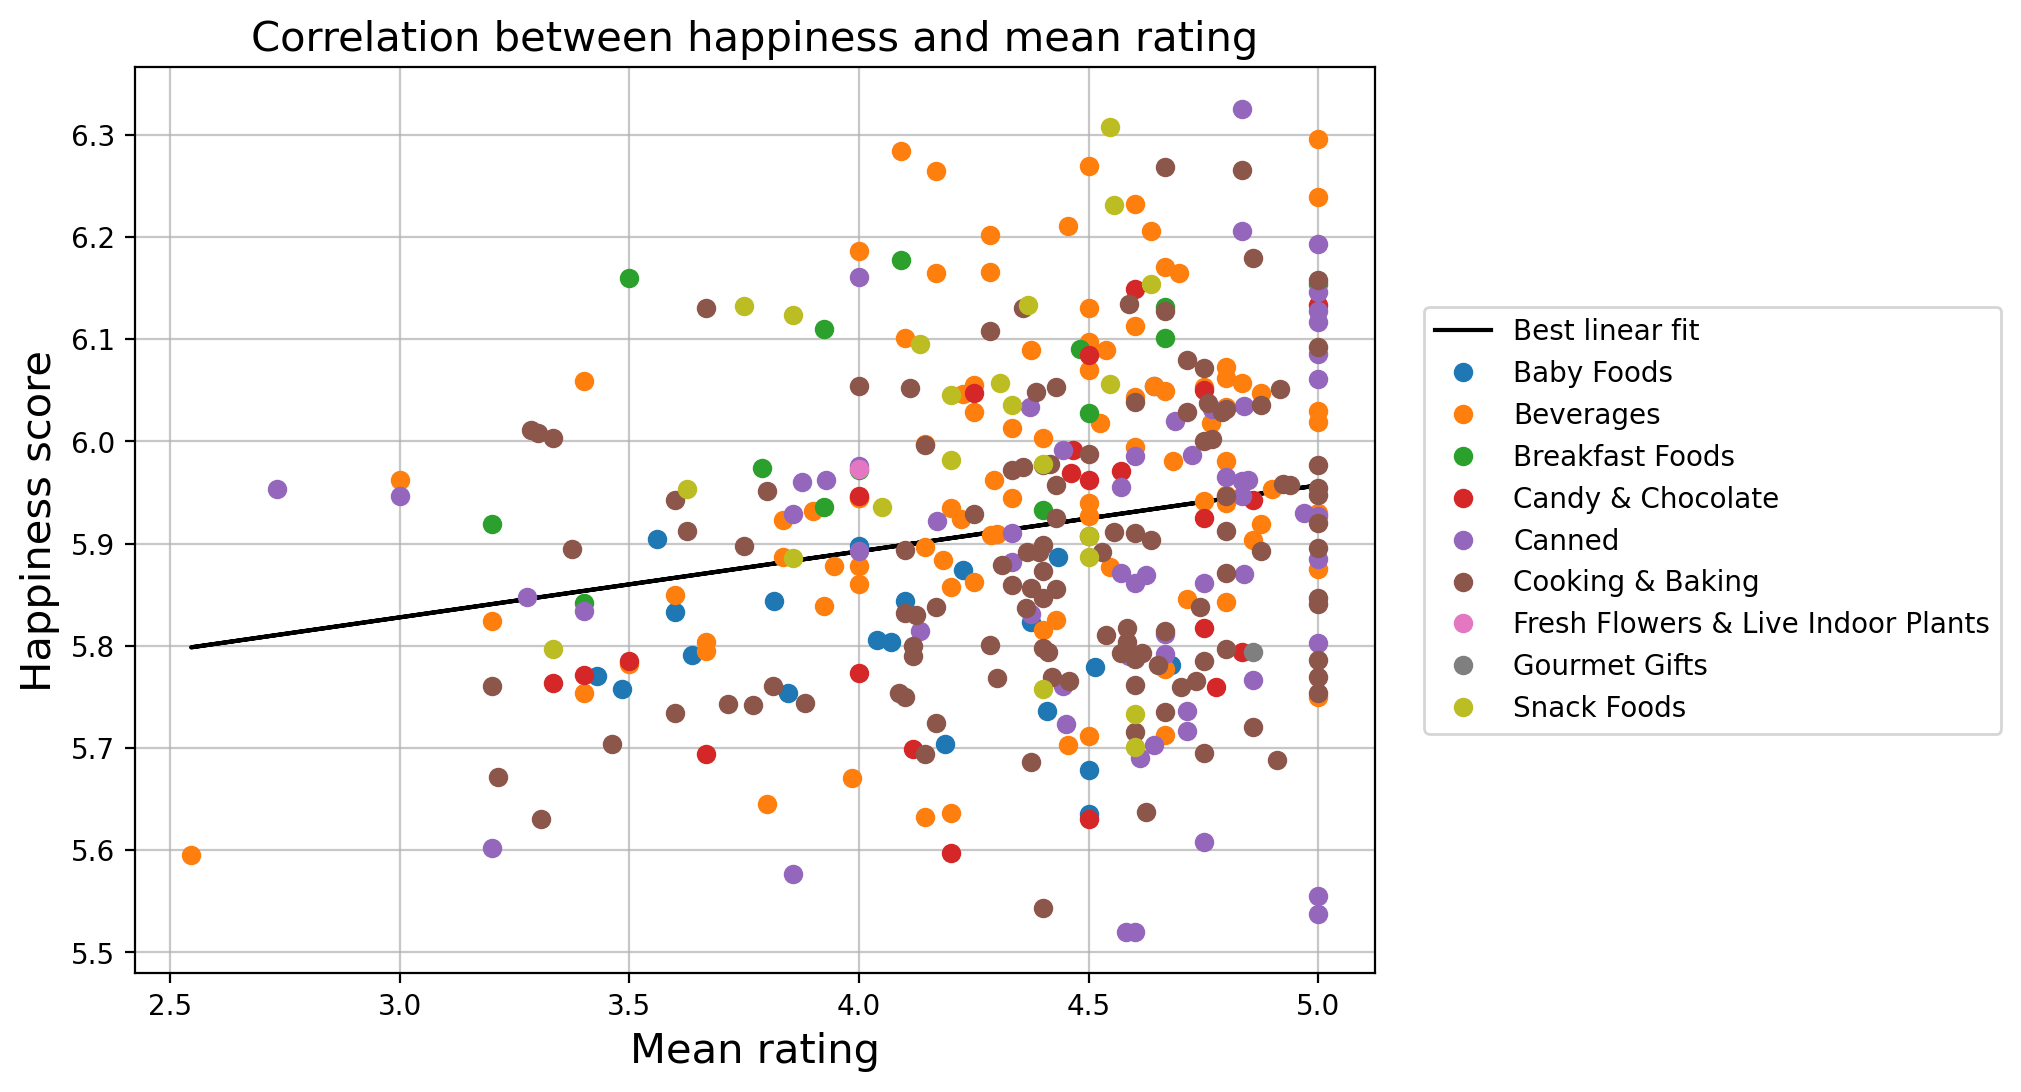

In [98]:
figure(figsize=(8, 6), dpi=200)

# linear fit
xs = product_df7['mean rating']
ys = product_df7['happiness score']
a, b = np.polyfit(xs, ys, 1)


plt.plot(xs, a*xs + b,"k", label = "Best linear fit")
for cat in np.unique(product_df7["category"]):
    idx = product_df7['category'] == cat
    xs = product_df7['mean rating'][idx]
    ys = product_df7['happiness score'][idx]
    plt.plot(xs, ys, "o", label = cat)

plt.grid(alpha=0.7)
plt.xlabel("Mean rating",size=15)
plt.ylabel("Happiness score",size=15)
plt.title("Correlation between happiness and mean rating", size=15)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

Testing if the linear correlation if significant with $N=358$ products:

In [99]:
# Pearson's correlation coefficient
xs = product_df7['mean rating']
ys = product_df7['happiness score']
stats.pearsonr(xs,ys)

(0.19550044075129125, 0.00019758558864514815)

The function stats.pearsonr outputs (correlation coefficient, p-value). The p-value is 0.0002, which clearly tells that there is a significant linear relationship between the mean rating and the happiness score of the products.

However, the correlation coefficient is only 0.196, indicating a not-so-powerful relationship between the two (likely due to the tabular method of the labTM happiness scores being too simple).

---
Calculating mean rating and mean sentiment for each food category (not used in the website):

In [101]:
# mean rating and mean happiness per category:
for cat in np.unique(product_df7["category"]):
    idx = product_df7['category'] == cat
    rating = np.mean(product_df7['mean rating'][idx])
    hap = np.mean(product_df7['happiness score'][idx])
    
    print("Category:",cat,"({} products)".format(np.sum(idx)))
    print("Mean happiness:",round(hap,3))
    print("Mean rating:",round(rating,3))
    print("\n")
    

Category: Baby Foods (21 products)
Mean happiness: 5.807
Mean rating: 4.097


Category: Beverages (95 products)
Mean happiness: 5.965
Mean rating: 4.353


Category: Breakfast Foods (14 products)
Mean happiness: 6.038
Mean rating: 4.11


Category: Candy & Chocolate (23 products)
Mean happiness: 5.881
Mean rating: 4.339


Category: Canned (61 products)
Mean happiness: 5.889
Mean rating: 4.493


Category: Cooking & Baking (120 products)
Mean happiness: 5.888
Mean rating: 4.418


Category: Fresh Flowers & Live Indoor Plants (1 products)
Mean happiness: 5.973
Mean rating: 4.0


Category: Gourmet Gifts (1 products)
Mean happiness: 5.794
Mean rating: 4.857


Category: Snack Foods (22 products)
Mean happiness: 5.995
Mean rating: 4.241




Linear correlation plots for each food category:

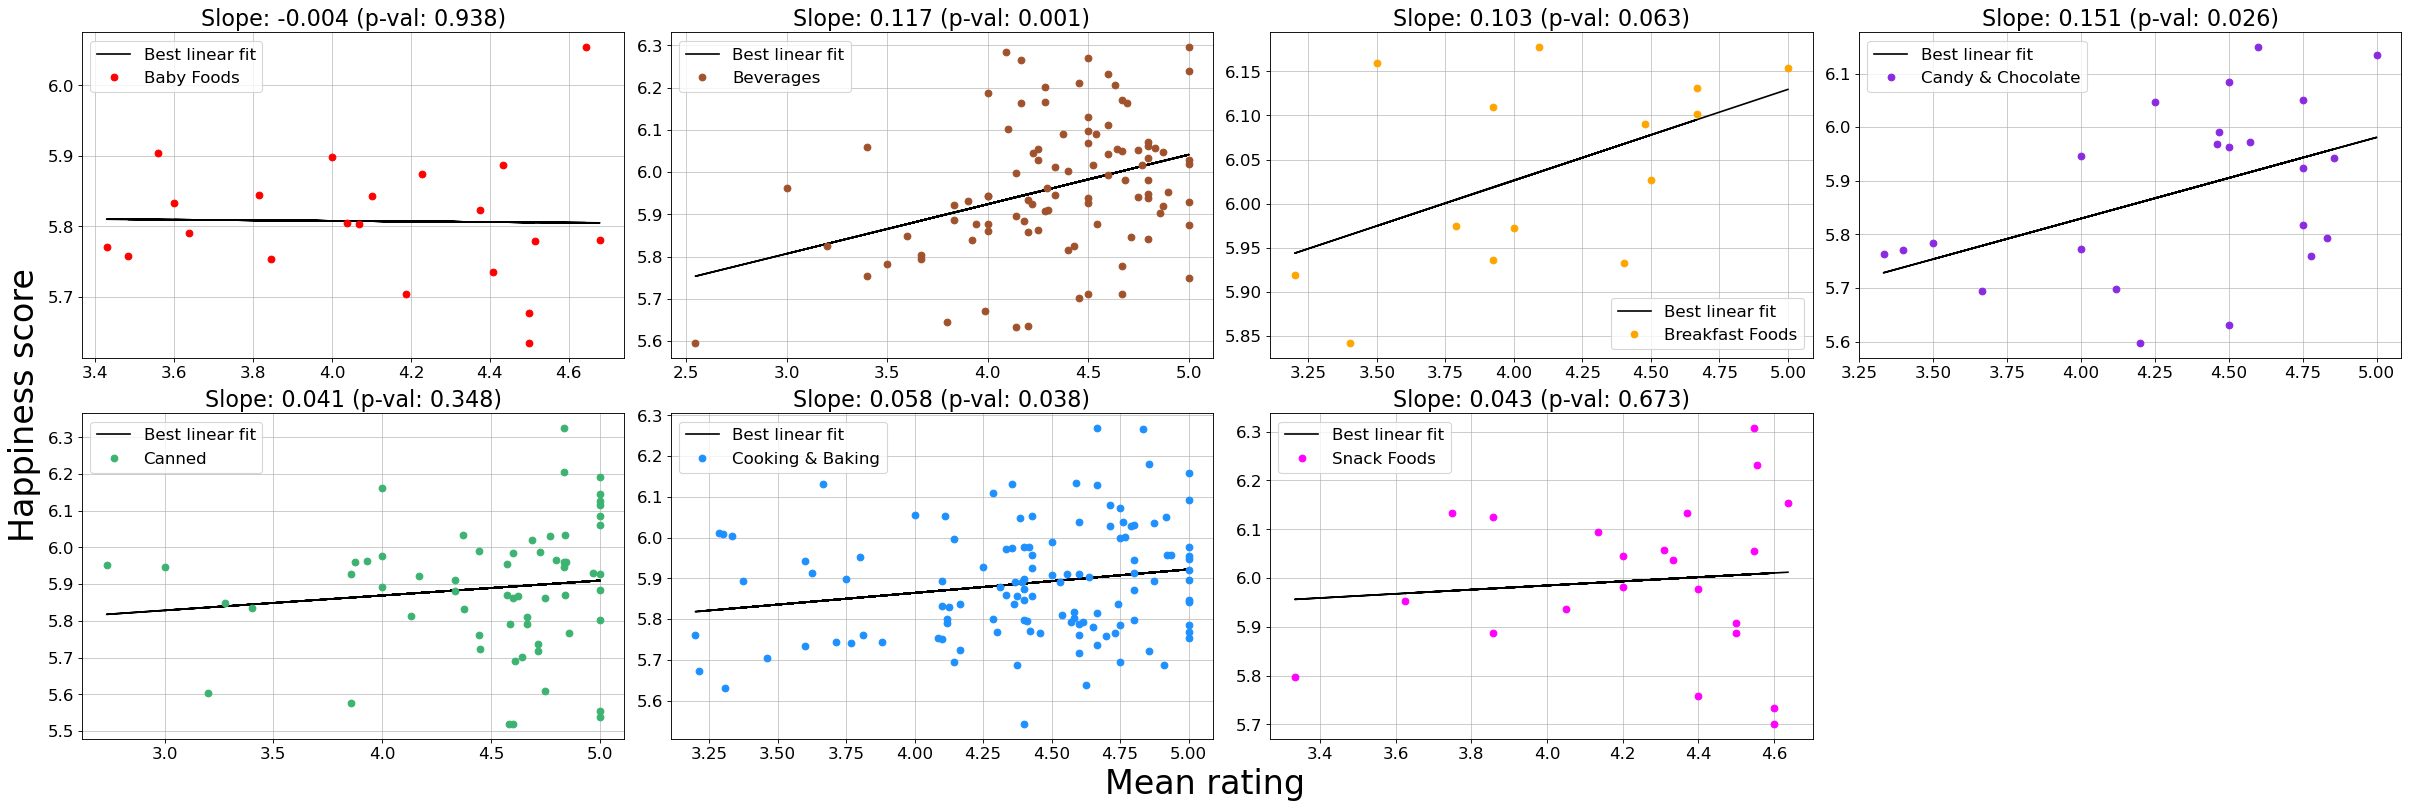

In [102]:
fig = plt.figure(figsize=(30,10),dpi=80, constrained_layout=True)

colors = ['red','sienna','orange','blueviolet','mediumseagreen','dodgerblue','fuchsia']
i=1
for cat in np.unique(product_df7["category"]):
    if cat not in ["Gourmet Gifts", "Fresh Flowers & Live Indoor Plants"]:
        ax = plt.subplot(2,4,i)

        idx = product_df7['category'] == cat
        xs = product_df7['mean rating'][idx]
        ys = product_df7['happiness score'][idx]
        # linear fit
        a, b = np.polyfit(xs, ys, 1)

        ax.plot(xs, a*xs + b,"k", label = "Best linear fit")
        ax.plot(xs, ys, "o", label = cat, color = colors[i-1])

        ax.grid(alpha=0.7)
        plt.title("Slope: {0} (p-val: {1})".format(round(a,3),round(stats.pearsonr(xs,ys)[1],3)), size=20)
        fig.supxlabel("Mean rating",size=30)
        fig.supylabel("Happiness score", size=30)
        
        ax.tick_params(axis='both', labelsize=15)
        ax.legend(fontsize=15)
        
        i+=1
        
plt.show()

# 4. Discussion

The product network gave satisfactory results, as we were able to confirm our hypothesis that the product category is a good partition with some distinct communities. 

The random network, which was constructed to have similar properties to the reviewer network, behaved like a truly random network. The degree distribution of the random network looks like a binomial distribution, and its average clustering coefficient was much lower than the reviewer network.

The reviewer network did not highlight the super users as well as we hoped, since a user with many reviews did not necessarily have a large node degree in the network, since an edge is only established between two nodes (representing two different users), if they have reviewed the same product. Therefore, a user with many reviews could potentially have low node degree if no other users have reviewed the same product as them. 

# 5. References


[1] http://networksciencebook.com/chapter/3#number-of-links

[2] http://networksciencebook.com/chapter/3#degree-distribution

[3] http://networksciencebook.com/chapter/2#clustering

[4] http://networksciencebook.com/chapter/3#clustering-3-9

[5] Our Assignment 2

[6] https://towardsdatascience.com/louvain-algorithm-93fde589f58c


# 6. Work distribution 

- Andreas Høst (s194238) performed the text analysis and the preprocessing necessary for that part.
- Malthe D. Andersen (s194257) performed the network analysis on the product network and the preprocessing necessary for that part.
- Yucheng Fu (s194241) performed the network analysis on the reviewer network and the preprocessing necessary for that part.
- All members of the group helped create the website and the explainer notebook.